In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import random 
from scipy.optimize import curve_fit
from sknn.mlp import Regressor, Layer

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1. Pasos iniciales

### 1.1 Cargamos los archivos

Cargamos cada archivo csv en un dataframe, uno para cada boya. Los datos están separados mediante tabulación (*sep*). Con *header* indicamos la línea en la que tiene que leer los nombres de las columnas (la primera línea viene vacía), y con *na_values* indicamos que los *missing values* se denotan por **-9999.9** (de esta forma Pandas los transforma automáticamente en **NaN**). Al utilizar la función *date_parser* los datos de la columna Fecha (GMT) se convierten en objetos de tipo **datetime**.

In [2]:
dateparse = lambda x: dt.datetime.strptime(x, '%Y %m %d  %H')
df1=pd.read_csv('cabo_silleiro.csv',sep='\t', header=1,parse_dates=['Fecha (GMT)'], date_parser=dateparse, na_values=[-9999.9])


df2=pd.read_csv('estaca_de_bares.csv',sep='\t', header=1, parse_dates=['Fecha (GMT)'], date_parser=dateparse, na_values=[-9999.9])


df3=pd.read_csv('villano_sisargas.csv',sep='\t', header=1, parse_dates=['Fecha (GMT)'], date_parser=dateparse, na_values=[-9999.9])


### 1.2 Mostramos la información de los archivos

Todas poseen los **mismos campos o columnas (21)**, pero diferente **número de instancias o registros**.

**Cabo Silleiro:**

In [3]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188284 entries, 0 to 188283
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Fecha (GMT)                                   188284 non-null  datetime64[ns]
 1   Altura Signif. del Oleaje (m)                 186786 non-null  float64       
 2   Periodo Medio Tm02 (s)                        186785 non-null  float64       
 3   Periodo de Pico (s)                           185944 non-null  float64       
 4   Altura Maxima del Oleaje (m)                  175723 non-null  float64       
 5   Periodo de la Ola Maxima (s)                  172937 non-null  float64       
 6   Canal de obtencion de los datos               188284 non-null  int64         
 7   Direcc. Media de Proced. (0=N,90=E)           152603 non-null  float64       
 8   Direcc. de pico de proced. (0=N,90=E)         152603 n

**Estaca de Bares:**

In [4]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178591 entries, 0 to 178590
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Fecha (GMT)                                   178591 non-null  datetime64[ns]
 1   Altura Signif. del Oleaje (m)                 166824 non-null  float64       
 2   Periodo Medio Tm02 (s)                        166824 non-null  float64       
 3   Periodo de Pico (s)                           166824 non-null  float64       
 4   Altura Maxima del Oleaje (m)                  146107 non-null  float64       
 5   Periodo de la Ola Maxima (s)                  143458 non-null  float64       
 6   Canal de obtencion de los datos               178591 non-null  int64         
 7   Direcc. Media de Proced. (0=N,90=E)           165734 non-null  float64       
 8   Direcc. de pico de proced. (0=N,90=E)         165734 n

**Vilán-Sisargas:**

In [5]:
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177126 entries, 0 to 177125
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Fecha (GMT)                                   177126 non-null  datetime64[ns]
 1   Altura Signif. del Oleaje (m)                 172756 non-null  float64       
 2   Periodo Medio Tm02 (s)                        172756 non-null  float64       
 3   Periodo de Pico (s)                           172756 non-null  float64       
 4   Altura Maxima del Oleaje (m)                  163740 non-null  float64       
 5   Periodo de la Ola Maxima (s)                  158807 non-null  float64       
 6   Canal de obtencion de los datos               177126 non-null  int64         
 7   Direcc. Media de Proced. (0=N,90=E)           172756 non-null  float64       
 8   Direcc. de pico de proced. (0=N,90=E)         172756 n

Vemos que el csv de Cabo Silleiro tiene **188284** instancias, el de Estaca de Bares **178591** y el de Vilán-Sisargas **177126**. También podemos hacernos ya una idea de la cantidad de *missing values* de cada magnitud.
Los tipos de dato por ahora no son importantes, porque los modificaremos a posteriori.

### 1.3 Mostramos las fechas de activación

Podemos comprobar la **primera fecha registrada** para cada boya. La **última fecha**, como ya se ha dicho, es para todos el **1/12/2021** a las **23 h**.

In [6]:
print('Cabo Silleiro: ',df1.loc[0]['Fecha (GMT)'])

Cabo Silleiro:  1998-07-06 20:00:00


In [7]:
print('Estaca de Bares: ',df2.loc[0]['Fecha (GMT)'])

Estaca de Bares:  1996-07-19 15:00:00


In [8]:
print('Vilan-Sisargas: ',df3.loc[0]['Fecha (GMT)'])

Vilan-Sisargas:  1998-05-13 00:00:00


Como vemos la primera estación en activarse es la de **Estaca de Bares**, seguida de **Vilán-Sisargas**, y la última es la de **Cabo Silleiro**.

### 1.4 Continuidad de las series temporales

Debemos observar si existe un registro para cada hora del día desde que se activan las boyas hasta el momento tomado como final (1/12/2021 a las 23:00), o si por el contrario hay **fechas no registradas**. Es necesario contar con todas las fechas, para trabajar con **series temporales continuas**. 

Con el siguiente código incluimos las fechas que no hayan sido registradas en cada archivo, y creamos tres nuevos archivos, ahora completos. Para eso se necesitan dataframes auxiliares, para ir guardando las fechas ya registradas y las nuevas. 

El código parte de la fecha de activación de cada boya y va sumándole una hora en cada ciclo, comprobando que coincida con el registro de la columna Fecha: si coincide, guarda la instancia completa correspondiente a esa fecha en el dataframe auxiliar y pasa al siguiente registro; si no coinciden significa que faltan fechas, por lo que incluye una instancia nueva en el dataframe auxiliar, con la fecha faltante y con los **demás atributos como NaN** (ya que no conocemos sus valores). 



#### <font color='red'>ESTE PASO CONLLEVA MUCHO TIEMPO DE EJECUCION. SE ADJUNTAN EN LA ENTREGA LOS ARCHIVOS RESULTANTES DE DICHA EJECUCION: Cabo_Silleiro_completo.csv, Estaca_de_Bares_completo.csv, Vilan_Sisargas_completo.csv </font>



In [ ]:
def completar_fechas(df,fecha):
    df_aux=pd.DataFrame(columns=df.columns)   
    i1=0
    i2=0
    while i1<(len(df)):
        fech=df.loc[i1]['Fecha (GMT)']
        if fech==fecha:
            df_aux.loc[i2]=df.loc[i1]
            i1+=1
        else:
            df_aux.loc[i2]=[fecha]+20*[np.nan]
        i2+=1 
        fecha=fecha+dt.timedelta(hours=1)
    return df_aux

###### CABO SILLEIRO:
df_aux_1=completar_fechas(df1,dt.datetime(1998,7,6,20))
df_aux_1.to_csv("Cabo_Silleiro_completo.csv",sep='\t',na_rep='NaN')
###### ESTACA DE BARES:
df_aux_2=completar_fechas(df2,dt.datetime(1996,7,19,15))
df_aux_2.to_csv("Estaca_de_Bares_completo.csv",sep='\t',na_rep='NaN')
###### VILAN-SISARGAS:
df_aux_3=completar_fechas(df3,dt.datetime(1998,5,13,0))
df_aux_3.to_csv("Vilan_Sisargas_completo.csv",sep='\t',na_rep='NaN')

### 1.5 Información actualizada

Cargamos los archivos completos y volvemos a mostrar la información, para ver como ha variado el número de instancias.
Ahora no es necesaria una función date_parser, porque Pandas transforma las fechas fácilmente a datetime al estar en formato Y-m-d H:M:S.

In [3]:
df1=pd.read_csv('Cabo_Silleiro_completo.csv',sep='\t', index_col=0, header=0, parse_dates=['Fecha (GMT)'])

df2=pd.read_csv('Estaca_de_bares_completo.csv',sep='\t', index_col=0, header=0, parse_dates=['Fecha (GMT)'])

df3=pd.read_csv('Vilan_Sisargas_completo.csv',sep='\t', index_col=0, header=0, parse_dates=['Fecha (GMT)'])

In [10]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205180 entries, 0 to 205179
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Fecha (GMT)                                   205180 non-null  datetime64[ns]
 1   Altura Signif. del Oleaje (m)                 186786 non-null  float64       
 2   Periodo Medio Tm02 (s)                        186785 non-null  float64       
 3   Periodo de Pico (s)                           185944 non-null  float64       
 4   Altura Maxima del Oleaje (m)                  175723 non-null  float64       
 5   Periodo de la Ola Maxima (s)                  172937 non-null  float64       
 6   Canal de obtencion de los datos               188284 non-null  float64       
 7   Direcc. Media de Proced. (0=N,90=E)           152603 non-null  float64       
 8   Direcc. de pico de proced. (0=N,90=E)         152603 n

El número de instancias de **Cabo Silleiro** ha pasado de **188284** a **205180**, es decir faltaban **16896** registros.

In [11]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222393 entries, 0 to 222392
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Fecha (GMT)                                   222393 non-null  datetime64[ns]
 1   Altura Signif. del Oleaje (m)                 166824 non-null  float64       
 2   Periodo Medio Tm02 (s)                        166824 non-null  float64       
 3   Periodo de Pico (s)                           166824 non-null  float64       
 4   Altura Maxima del Oleaje (m)                  146107 non-null  float64       
 5   Periodo de la Ola Maxima (s)                  143458 non-null  float64       
 6   Canal de obtencion de los datos               178591 non-null  float64       
 7   Direcc. Media de Proced. (0=N,90=E)           165734 non-null  float64       
 8   Direcc. de pico de proced. (0=N,90=E)         165734 n

El número de instancias de **Estaca de Bares** ha pasado de **178591** a **222393**, es decir faltaban **43802** registros.

In [12]:
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206496 entries, 0 to 206495
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Fecha (GMT)                                   206496 non-null  datetime64[ns]
 1   Altura Signif. del Oleaje (m)                 172756 non-null  float64       
 2   Periodo Medio Tm02 (s)                        172756 non-null  float64       
 3   Periodo de Pico (s)                           172756 non-null  float64       
 4   Altura Maxima del Oleaje (m)                  163740 non-null  float64       
 5   Periodo de la Ola Maxima (s)                  158807 non-null  float64       
 6   Canal de obtencion de los datos               177126 non-null  float64       
 7   Direcc. Media de Proced. (0=N,90=E)           172756 non-null  float64       
 8   Direcc. de pico de proced. (0=N,90=E)         172756 n

El número de instancias de **Vilán-Sisargas** ha pasado de **177126** a **206496**, es decir faltaban **29370** registros.

# 2. Unificación del dataset

### 2.1 Añadimos un nuevo campo en los dataframe 

Dicho campo contiene el nombre de cada boya, y permitirá **diferenciar** los datos cuando estén en el mismo archivo. Lo situamos a la izquierda de las demás columnas. 

In [4]:
df1.insert(0,'Boya','Cabo Silleiro')
df2.insert(0,'Boya','Estaca de Bares')
df3.insert(0,'Boya','Vilan Sisargas')

### 2.2 Concatenamos los dataframe y lo guardamos en un nuevo archivo

El orden de concatenación se corresponde con el orden de activación de las boyas.
Al incluir *ignore_index=True*, pandas ignora el índice de los dataframe individuales y crea uno nuevo, de 0 al total de instancias (**634069**). El archivo resultante, *Datos_3boyas*, es sobre el que aplicaremos el **proceso de limpieza de datos**.

In [5]:
df=[df2,df3,df1]
df=pd.concat(df,ignore_index=True)
df.index.name='id'
df.to_csv("Datos_3boyas.csv",sep='\t',na_rep='NaN')

Mostramos la dimensión del dataset:

In [6]:
print(df.shape)

(634069, 22)


Ahora el número de columnas es **22** por haber añadido *Boya*.

### 2.3 Separamos la columna Fecha (GMT) en varios campos

Separar la fecha completa en **año**, **mes**, **día** y **hora**, nos permitirá filtrar los datos por mes, año, etc, muy útil para datos meteorológicos.

In [7]:
df.insert(2,'Anyo',df['Fecha (GMT)'].dt.year)
df.insert(3,'Mes',df['Fecha (GMT)'].dt.month)
df.insert(4,'Dia',df['Fecha (GMT)'].dt.day)
df.insert(5,'Hora',df['Fecha (GMT)'].dt.hour)

Comprobamos que se haya realizado correctamente. El número de columnas pasa a ser **26**.

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634069 entries, 0 to 634068
Data columns (total 26 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Boya                                          634069 non-null  object        
 1   Fecha (GMT)                                   634069 non-null  datetime64[ns]
 2   Anyo                                          634069 non-null  int64         
 3   Mes                                           634069 non-null  int64         
 4   Dia                                           634069 non-null  int64         
 5   Hora                                          634069 non-null  int64         
 6   Altura Signif. del Oleaje (m)                 526366 non-null  float64       
 7   Periodo Medio Tm02 (s)                        526365 non-null  float64       
 8   Periodo de Pico (s)                           525524 n

# 3. Limpieza de datos de las magnitudes secundarias

## 3.1 Missing values

Procedemos a tratar los *missing values* de nuestro dataset.

### 3.1.1 Oleaje. Altura y periodo.

A través de un *heatmap* vemos los valores faltantes de las variables asociadas al oleaje (*missing values* en <font color='red'>rojo</font>) :

<AxesSubplot:ylabel='id'>

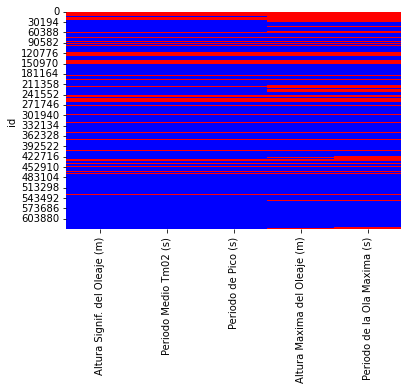

In [9]:
cols = df.columns[6:11]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

Vemos que las etapas de *missing values* coinciden para todas las variables, pero la **altura máxima** (Hm) y el **periodo de ola máxima** poseen alguna etapa a mayores. Es decir, en las instancias en las que falta la **altura significante** (Hs) también faltará la **altura máxima**, pero habrá instancias en las que falte la altura máxima pero no la altura significante. 

Como ya se ha comentado teóricamente se cumple que $Hm \approx 2\cdot Hs$. Por lo tanto en las fechas en las que contamos con la altura significante, pero falta la altura máxima, podemos calcularla. Pero para mayor fidelidad tomaremos el valor experimental de nuestro dataset. Para eso calculamos el valor medio del cociente entre la **altura máxima** y la altura **significante**, con los pares completos.

In [10]:
cociente=df['Altura Maxima del Oleaje (m)']/df['Altura Signif. del Oleaje (m)']
factor=cociente.mean()
print(factor)

1.5303121379140343


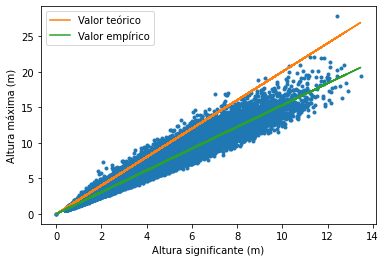

In [11]:
plt.plot(df['Altura Signif. del Oleaje (m)'],df['Altura Maxima del Oleaje (m)'],'.')
plt.plot(df['Altura Signif. del Oleaje (m)'],2.*df['Altura Signif. del Oleaje (m)'],'-',label='Valor teórico')
plt.plot(df['Altura Signif. del Oleaje (m)'],factor*df['Altura Signif. del Oleaje (m)'],'-',label='Valor empírico')
plt.xlabel('Altura significante (m)')
plt.ylabel('Altura máxima (m)')
plt.legend()

Rellenamos entonces los valores de la altura máxima con la ayuda de la altura significante. Antes mostramos el porcentaje inicial de *missing values* de la altura máxima:

In [12]:
def porcentaje_nan (df,variable):
    non_null=df[variable].count()
    porcent_NaN=(len(df)-non_null)/len(df)*100.
    print (round(porcent_NaN,2),'%') 

In [13]:
porcentaje_nan(df,'Altura Maxima del Oleaje (m)')

23.42 %


In [14]:
df['Altura Maxima del Oleaje (m)']=df['Altura Maxima del Oleaje (m)'].fillna(round(factor*df['Altura Signif. del Oleaje (m)'],2))

In [15]:
porcentaje_nan(df,'Altura Maxima del Oleaje (m)')

16.99 %


Ahora tratamos las instancias en las que falta tanto la altura significante como la altura máxima. Completamos la **altura significante** con los **valores medios mensuales**. Una vez tenemos las alturas significantes, rellenamos la altura máxima al igual que antes.


En la siguiente figura podemos ver el comportamiento del oleaje con respecto al mes:

<AxesSubplot:xlabel='Mes'>

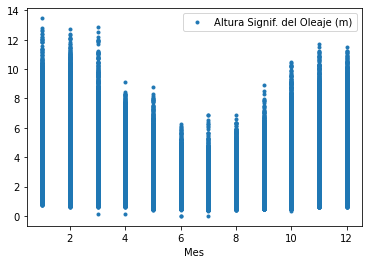

In [16]:
df.plot('Mes','Altura Signif. del Oleaje (m)',style='.')

In [17]:
#Funcion que calcula la media mensual de una variable
#Devuelve una media para cada mes del año
def media_mensual(variable):
    lista_mes=[]
    for mes in range(1,13):
        df_mes = df[df['Mes'] == mes]
        media=df_mes[variable].mean()
        lista_mes.append(media)  
    return lista_mes

In [18]:
lista_s=media_mensual('Altura Signif. del Oleaje (m)')
for mes in range(1,13):
    df.loc[(df['Mes']==mes) & df['Altura Signif. del Oleaje (m)'].isnull(),'Altura Signif. del Oleaje (m)']=round(lista_s[mes-1],2)

Una vez tenemos las alturas significantes completamos las alturas máximas:

In [19]:
df['Altura Maxima del Oleaje (m)']=df['Altura Maxima del Oleaje (m)'].fillna(round(factor*df['Altura Signif. del Oleaje (m)'],2))

Comprobamos que las magnitudes ya no contienen ningún valor NaN:

In [20]:
porcentaje_nan(df,'Altura Maxima del Oleaje (m)')
porcentaje_nan(df,'Altura Signif. del Oleaje (m)')

0.0 %
0.0 %


Finalmente podemos comprobar como la distribución de la altura de las olas tiende a la de Rayleigh.

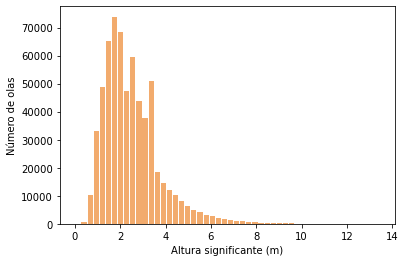

In [21]:
plt.hist(df['Altura Signif. del Oleaje (m)'], bins=50, color='#F2AB6D', rwidth=0.85)
plt.xlabel('Altura significante (m)')
plt.ylabel('Número de olas')
#plt.xticks(np.arange(0,370,40))
plt.show() 

Proseguimos con los periodos. Veamos su relación con la **altura máxima**.

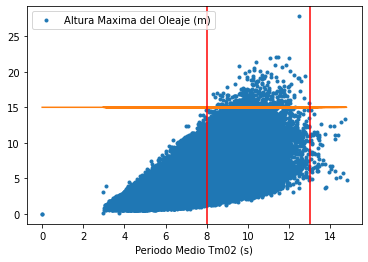

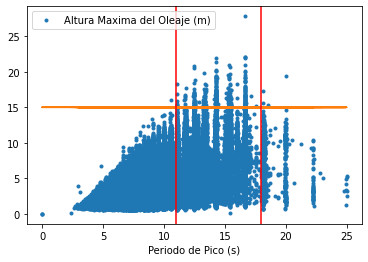

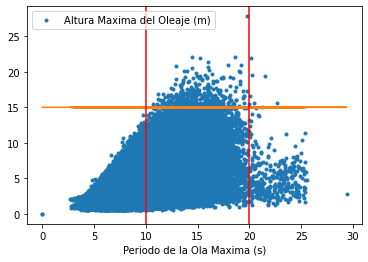

In [22]:
df.plot('Periodo Medio Tm02 (s)','Altura Maxima del Oleaje (m)',style='.')
plt.plot(df['Periodo Medio Tm02 (s)'],[15.]*len(df),'-')
plt.axvline(x=8, ymin=0, ymax=27, color='red')
plt.axvline(x=13, ymin=0, ymax=27, color='red')
df.plot('Periodo de Pico (s)','Altura Maxima del Oleaje (m)',style='.')
plt.plot(df['Periodo de Pico (s)'],[15.]*len(df),'-')
plt.axvline(x=11, ymin=0, ymax=27, color='red')
plt.axvline(x=18, ymin=0, ymax=27, color='red')
df.plot('Periodo de la Ola Maxima (s)','Altura Maxima del Oleaje (m)',style='.')
plt.plot(df['Periodo de la Ola Maxima (s)'],[15.]*len(df),'-')
plt.axvline(x=10, ymin=0, ymax=27, color='red')
plt.axvline(x=20, ymin=0, ymax=27, color='red')

Observamos que existe una distribución bastante definida, que recuerda a la **gaussiana**, parcialmente asimétrica. Esta nos muestra que las olas **más altas** poseen un periodo de pico en torno a los **15 s**. En cambio para los periodos más cortos (**<5 s**) y más largos (**>20 s**) solo ocurren olas de **poca altura**. 
Esto nos podría ayudar, a *grosso modo*, a rellenar los periodos para las alturas máximas mayores de **15 m**. Así para el periodo medio tomaríamos un valor entre **8** y **13 s**, para el de pico entre **11** y **18 s** y para el de ola máxima entre **10** y **20 s**.

Pero si comprobamos, vemos que para el periodo medio y el de pico no existen registros con altura máxima mayor a 15, que carezcan de dichos periodos (ambas magnitudes tienen las mismas etapas de *missing values*). Dicho de otra forma: todas las instancias con altura máxima mayor que 15 cuentan con valores para el periodo medio y de pico.


In [23]:
print(df.loc[(df['Altura Maxima del Oleaje (m)']>15)& df['Periodo Medio Tm02 (s)'].isnull(),['Altura Maxima del Oleaje (m)','Periodo Medio Tm02 (s)']])

Empty DataFrame
Columns: [Altura Maxima del Oleaje (m), Periodo Medio Tm02 (s)]
Index: []


Para el periodo de ola máxima hay pocos registros con dicha condición, por lo que rellenarlos no supondrá mucho cambio en el porcentaje de *missing values*.

In [24]:
print(df.loc[(df['Altura Maxima del Oleaje (m)']>15)& (df['Periodo de la Ola Maxima (s)'].isnull()),['Altura Maxima del Oleaje (m)','Periodo de la Ola Maxima (s)']])

        Altura Maxima del Oleaje (m)  Periodo de la Ola Maxima (s)
id                                                                
37693                          15.04                           NaN
37694                          15.17                           NaN
37695                          15.59                           NaN
37696                          17.05                           NaN
421556                         15.39                           NaN
421557                         16.64                           NaN
421559                         15.16                           NaN


In [25]:
porcentaje_nan(df,'Periodo de la Ola Maxima (s)')

25.06 %


In [26]:
df.loc[(df['Altura Maxima del Oleaje (m)']>15)& df['Periodo de la Ola Maxima (s)'].isnull(),'Periodo de la Ola Maxima (s)']=random.randint(1000,2000)/100

En vez de usar *random.randint(10,20)* usamos *random.randint(1000,2000)/100*, para poder obtener números con **dos decimales** entre **10** y **20**, pues las medidas de los periodos tienen esa precisión.

In [27]:
porcentaje_nan(df,'Periodo de la Ola Maxima (s)')

25.05 %


Todos los demás *missing values* del periodo de ola máxima y todos los del periodo medio y de pico, los rellenaremos haciendo uso de *interpolate*, con el método *time*. Para eso tenemos que definir la fecha como índice del dataframe.

Vemos la gráfica del **periodo de pico** para el año 1998, en la que se aprecian las etapas de valores faltantes:

<AxesSubplot:xlabel='Fecha (GMT)'>

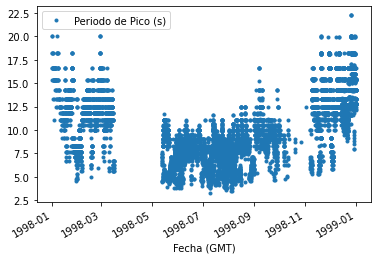

In [28]:
df_1998=df[df['Anyo'] ==1998]
df_1998.plot('Fecha (GMT)','Periodo de Pico (s)',style='.')

In [29]:
df.index=df['Fecha (GMT)']
df['Periodo de Pico (s)']=round(df['Periodo de Pico (s)'].interpolate('time'),2)
df=df.reset_index(drop=True)

<AxesSubplot:xlabel='Fecha (GMT)'>

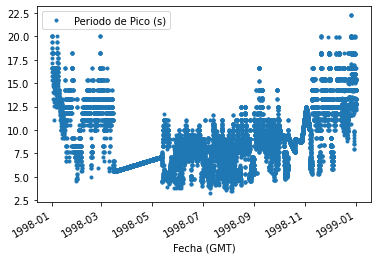

In [30]:
df2_1998=df[df['Anyo'] ==1998]
df2_1998.plot('Fecha (GMT)','Periodo de Pico (s)',style='.')

Como apreciamos en la gráfica interpolada, este método es bastante simplista, pero sirve para completar las magnitudes sobre las que no se va a trabajar. Rellenamos también el periodo medio y de ola máxima, con el mismo método:

In [31]:
df.index=df['Fecha (GMT)']
df['Periodo Medio Tm02 (s)']=round(df['Periodo Medio Tm02 (s)'].interpolate('time'),2)
df['Periodo de la Ola Maxima (s)']=round(df['Periodo de la Ola Maxima (s)'].interpolate('time'),2)
df=df.reset_index(drop=True)

Comprobamos que no queden valores NaN en las tres magnitudes:

In [32]:
porcentaje_nan(df,'Periodo Medio Tm02 (s)')
porcentaje_nan(df,'Periodo de Pico (s)')
porcentaje_nan(df,'Periodo de la Ola Maxima (s)')

0.0 %
0.0 %
0.0 %


### 3.1.2 Oleaje. Dirección

Observamos el *heatmap* para las tres magnitudes de dirección:

<AxesSubplot:>

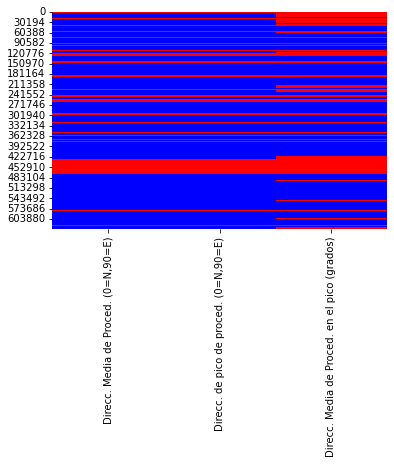

In [33]:
cols = df.columns[12:15]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours), cbar=False)

Estas magnitudes no empiezan a medirse en el momento de activación de la primera boya (Estaca de Bares), por lo que existe una etapa en la ninguna boya las está midiendo. Estos *missing values*, como ya se ha comentado, seguirán siendo indeterminados, pero en vez de NaN los indicaremos con -1, que no tiene sentido físico, ya que las direcciones son ángulos positivos.

En el *heatmap* se aprecia también una gran franja de valores faltantes. Esta se corresponde a Cabo Silleiro, ya que desde que se activa dicha boya pasan años hasta que cuenta con sensores para las diferentes direcciones del oleaje. Esos valores no hay que sustituirlos por -1, ya que en ese momento las magnitudes en cuestión están siendo medidas por las otras dos boyas. También se aprecia que las etapas de medida de la **dirección media** y de **pico** coinciden, mientras que la **dirección media en el pico** contiene más *missing values*.

Procedamos a buscar las fechas de inicio de medida de estas magnitudes, para poder reemplazar por -1 los valores anteriores a dicha fecha.

In [34]:
df_estaca=df[(df['Boya']=='Estaca de Bares') & (df['Direcc. Media de Proced. (0=N,90=E)'].notna())]
print('Primera medida de la dirección media en Estaca de Bares:',df_estaca['Fecha (GMT)'].head(1))
df_estaca_2=df[(df['Boya']=='Estaca de Bares') & (df['Direcc. de pico de proced. (0=N,90=E)'].notna())]
print('Primera medida de la dirección de pico en Estaca de Bares:',df_estaca_2['Fecha (GMT)'].head(1))
df_estaca_3=df[(df['Boya']=='Estaca de Bares') & (df['Direcc. Media de Proced. en el pico (grados)'].notna())]
print('Primera medida de la dirección media en el pico en Estaca de Bares:',df_estaca_3['Fecha (GMT)'].head(1))

Primera medida de la dirección media en Estaca de Bares: 4710   1997-01-31 21:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la dirección de pico en Estaca de Bares: 4710   1997-01-31 21:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la dirección media en el pico en Estaca de Bares: 15920   1998-05-13 23:00:00
Name: Fecha (GMT), dtype: datetime64[ns]


En **Estaca de Bares** la dirección **media** y de **pico** empiezan a medirse en el mismo instante, en **enero de 1997**. La dirección **media en el pico** empieza más tarde, en **mayo de 1998**.

In [35]:
df_vilan=df[(df['Boya']=='Vilan Sisargas') & (df['Direcc. Media de Proced. (0=N,90=E)'].notna())]
print('Primera medida de la dirección media en Vilán-Sisargas:',df_vilan['Fecha (GMT)'].head(1))
df_vilan_2=df[(df['Boya']=='Vilan Sisargas') & (df['Direcc. de pico de proced. (0=N,90=E)'].notna())]
print('Primera medida de la dirección de pico en Vilán-Sisargas:',df_vilan_2['Fecha (GMT)'].head(1))
df_vilan_3=df[(df['Boya']=='Vilan Sisargas') & (df['Direcc. Media de Proced. en el pico (grados)'].notna())]
print('Primera medida de la dirección media en el pico en Vilán-Sisargas:',df_vilan_3['Fecha (GMT)'].head(1))

Primera medida de la dirección media en Vilán-Sisargas: 222393   1998-05-13
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la dirección de pico en Vilán-Sisargas: 222393   1998-05-13
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la dirección media en el pico en Vilán-Sisargas: 222393   1998-05-13
Name: Fecha (GMT), dtype: datetime64[ns]


En **Vilán-Sisargas** las tres magnitudes empiezan a medirse en el mismo momento de su activación, el **13/5/1998** a las **0 h**.

In [36]:
df_silleiro=df[(df['Boya']=='Cabo Silleiro') & (df['Direcc. Media de Proced. (0=N,90=E)'].notna())]
print('Primera medida de la dirección media en Cabo Silleiro:',df_silleiro['Fecha (GMT)'].head(1))
df_silleiro_2=df[(df['Boya']=='Cabo Silleiro') & (df['Direcc. de pico de proced. (0=N,90=E)'].notna())]
print('Primera medida de la dirección de pico en Cabo Silleiro:',df_silleiro_2['Fecha (GMT)'].head(1))
df_silleiro_3=df[(df['Boya']=='Cabo Silleiro') & (df['Direcc. Media de Proced. en el pico (grados)'].notna())]
print('Primera medida de la dirección media en el pico en Cabo Silleiro:',df_silleiro_3['Fecha (GMT)'].head(1))

Primera medida de la dirección media en Cabo Silleiro: 471433   2003-05-14 12:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la dirección de pico en Cabo Silleiro: 471433   2003-05-14 12:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la dirección media en el pico en Cabo Silleiro: 471433   2003-05-14 12:00:00
Name: Fecha (GMT), dtype: datetime64[ns]


En **Cabo Silleiro** las tres magnitudes empiezan a medirse en el mismo instante, mucho más tarde que su activación, en el año **2003**.

Por lo tanto el primer registro de las direcciones **media** y de **pico** se da el **31/1/1997** a las **21 h** y el de la **media en el pico** se da el  **13/5/1998** a las **0 h**. Realizamos entonces el cambio de NaN a -1 para los *missing values* anteriores a la fecha correspondiente para cada magnitud. **Estaca de Bares** es la única que ya estaba midiendo en esas fechas, por lo que este cambio solo afectará a sus instancias.

In [37]:
df.loc[:4709,['Direcc. Media de Proced. (0=N,90=E)','Direcc. de pico de proced. (0=N,90=E)']]

,"Direcc. Media de Proced. (0=N,90=E)","Direcc. de pico de proced. (0=N,90=E)"
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
4705,NaN,NaN
4706,NaN,NaN
4707,NaN,NaN
4708,NaN,NaN


In [38]:
df[(df['Boya']=='Estaca de Bares') & (df['Fecha (GMT)']==dt.datetime(1998,5,13,0))].index

Int64Index([15897], dtype='int64')

In [39]:
df.loc[:15896,['Direcc. Media de Proced. en el pico (grados)']]

,Direcc. Media de Proced. en el pico (grados)
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
15892,NaN
15893,NaN
15894,NaN
15895,NaN


Hacemos el cambio:

In [40]:
df.loc[:4709,['Direcc. Media de Proced. (0=N,90=E)','Direcc. de pico de proced. (0=N,90=E)']]=-1
df.loc[:15896,'Direcc. Media de Proced. en el pico (grados)']=-1

Comprobamos que se ha realizado correctamente:

In [41]:
df.loc[:4709,['Direcc. Media de Proced. (0=N,90=E)','Direcc. de pico de proced. (0=N,90=E)']]

,"Direcc. Media de Proced. (0=N,90=E)","Direcc. de pico de proced. (0=N,90=E)"
0,-1.0,-1.0
1,-1.0,-1.0
2,-1.0,-1.0
3,-1.0,-1.0
4,-1.0,-1.0
...,...,...
4705,-1.0,-1.0
4706,-1.0,-1.0
4707,-1.0,-1.0
4708,-1.0,-1.0


In [42]:
df.loc[:15896,['Direcc. Media de Proced. en el pico (grados)']]

,Direcc. Media de Proced. en el pico (grados)
0,-1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0
...,...
15892,-1.0
15893,-1.0
15894,-1.0
15895,-1.0


Los demás valores faltantes de las tres magnitudes los rellenaremos con el valor más frecuente de todas las instancias.

Comprobamos que el valor más frecuente mensual coincide en todos los meses para la **dirección media** y la **de pico**, por lo que no es necesario tratar los *missing values* de manera diferenciada para cada mes.

In [43]:
#Funcion que devuelve un diccionario con el intervalo de mayor frecuencia de cada mes
def valor_mas_frecuente_mensual (variable,minim,maxim,paso):
    num_interv=(maxim-minim)//paso
    dic_mes={}
    for mes in range(1,13):
        frecuencias={}
        df_mes = df[df['Mes'] == mes]
        for i in range(num_interv):
            cuenta=(df_mes.loc[(df_mes[variable]>=paso*i) & (df_mes[variable]<paso*(i+1)),variable]).count()
            frecuencias[i]=cuenta
        clave_max = max(frecuencias, key=lambda k: frecuencias[k])
        dic_mes[mes]=(paso*clave_max,paso*(clave_max+1))
    return dic_mes   

In [44]:
print(valor_mas_frecuente_mensual ('Direcc. Media de Proced. (0=N,90=E)',0,360,20))
print(valor_mas_frecuente_mensual ('Direcc. de pico de proced. (0=N,90=E)',0,360,20))

{1: (300, 320), 2: (300, 320), 3: (300, 320), 4: (300, 320), 5: (300, 320), 6: (300, 320), 7: (300, 320), 8: (300, 320), 9: (300, 320), 10: (300, 320), 11: (300, 320), 12: (300, 320)}
{1: (300, 320), 2: (300, 320), 3: (300, 320), 4: (300, 320), 5: (300, 320), 6: (300, 320), 7: (300, 320), 8: (300, 320), 9: (300, 320), 10: (300, 320), 11: (300, 320), 12: (300, 320)}


Vemos dos ejemplos, para la **dirección media**, para los meses de enero y agosto: 

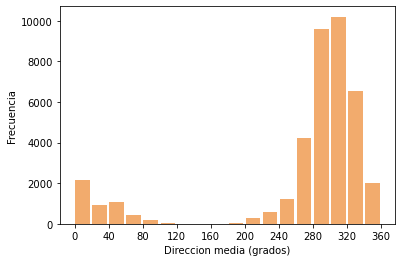

In [45]:
df_enero=df[df['Mes']==1]
intervalos=np.arange(0,370,20)
plt.hist(df_enero['Direcc. Media de Proced. (0=N,90=E)'], bins=18, color='#F2AB6D', rwidth=0.85)
plt.xlabel('Direccion media (grados)')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(0,370,40))
plt.show() 

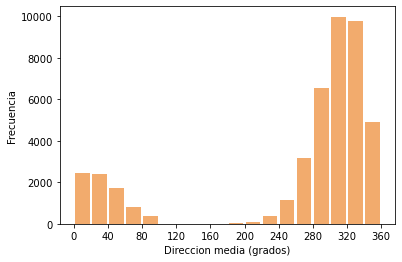

In [46]:
df_agosto=df[df['Mes']==8]
intervalos=np.arange(0,370,20)
plt.hist(df_agosto['Direcc. Media de Proced. (0=N,90=E)'], bins=intervalos, color='#F2AB6D', rwidth=0.85)
plt.xlabel('Direccion media (grados)')
plt.ylabel('Frecuencia')
plt.xticks(np.arange(0,370,40))
plt.show() 

La dirección más frecuente se sitúa en el intervalo (300,320), por lo tanto rellenaremos todos los NaN de estas dos magnitudes con un **valor aleatorio entre 300 y 320**. Otra forma sería con el valor medio del intervalo, 310.

Estes son los porcentajes de *missing values*:

In [47]:
porcentaje_nan(df,'Direcc. Media de Proced. (0=N,90=E)')
porcentaje_nan(df,'Direcc. de pico de proced. (0=N,90=E)')

21.81 %
21.81 %


In [48]:
df['Direcc. Media de Proced. (0=N,90=E)']=df['Direcc. Media de Proced. (0=N,90=E)'].fillna(random.randint(300,320))
df['Direcc. de pico de proced. (0=N,90=E)']=df['Direcc. de pico de proced. (0=N,90=E)'].fillna(random.randint(300,320))

Comprobamos como se reducen los porcentajes:

In [49]:
porcentaje_nan(df,'Direcc. Media de Proced. (0=N,90=E)')
porcentaje_nan(df,'Direcc. de pico de proced. (0=N,90=E)')

0.0 %
0.0 %


La **dirección media en el pico**, al contrario que las dos anteriores, va de **0** a **90** grados. Al igual que antes, el valor más frecuente mensual coincide con el total: el intervalo (20,30). Por lo tanto rellenamos los datos faltantes con un valor aleatorio entre esos extremos.

In [50]:
print(valor_mas_frecuente_mensual ('Direcc. Media de Proced. en el pico (grados)',0,90,10))

{1: (20, 30), 2: (20, 30), 3: (20, 30), 4: (20, 30), 5: (20, 30), 6: (20, 30), 7: (20, 30), 8: (20, 30), 9: (20, 30), 10: (20, 30), 11: (20, 30), 12: (20, 30)}


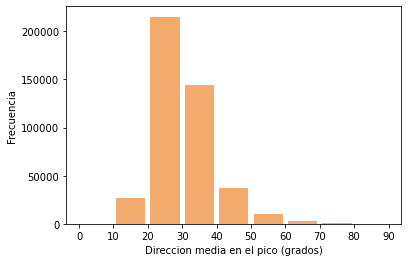

In [51]:
intervalos=np.arange(0,100,10)
plt.hist(df['Direcc. Media de Proced. en el pico (grados)'], bins=intervalos, color='#F2AB6D', rwidth=0.85)
plt.xlabel('Direccion media en el pico (grados)')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)
plt.show() 

In [52]:
porcentaje_nan(df,'Direcc. Media de Proced. en el pico (grados)')

28.4 %


In [53]:
df['Direcc. Media de Proced. en el pico (grados)']=df['Direcc. Media de Proced. en el pico (grados)'].fillna(random.randint(20,30))

In [54]:
porcentaje_nan(df,'Direcc. Media de Proced. en el pico (grados)')

0.0 %


### 3.1.3 Corriente y viento. Velocidad y dirección.

Vemos el *heatmap* para la **corriente  marítima** y el **viento**:

<AxesSubplot:>

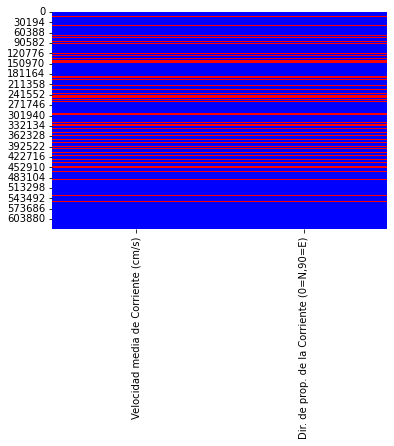

In [55]:
col = df.columns[18:20]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(df[col].isnull(), cmap=sns.color_palette(colours), cbar=False)

<AxesSubplot:>

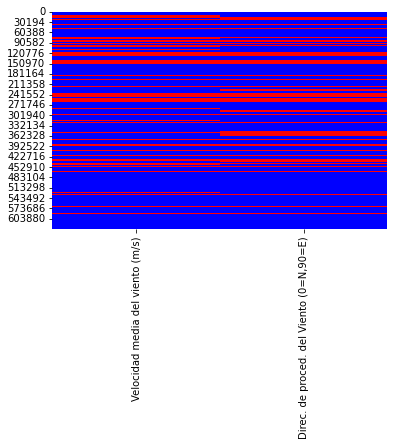

In [56]:
col = df.columns[23:25]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(df[col].isnull(), cmap=sns.color_palette(colours), cbar=False)

Las cuatro magnitudes empiezan a medirse casi desde la fecha de activación de la primera boya, por lo que habrá que cambiar pocos valores NaN por -1:



In [57]:
print(df[['Velocidad media de Corriente (cm/s)','Velocidad media del viento (m/s)','Dir. de prop. de la Corriente (0=N,90=E)','Direc. de proced. del Viento (0=N,90=E)']].head())

   Velocidad media de Corriente (cm/s)  Velocidad media del viento (m/s)  \
0                                  NaN                               NaN   
1                                  NaN                               NaN   
2                                 17.4                               NaN   
3                                 24.5                               NaN   
4                                 27.2                               1.6   

   Dir. de prop. de la Corriente (0=N,90=E)  \
0                                       NaN   
1                                       NaN   
2                                     339.0   
3                                     352.0   
4                                     358.0   

   Direc. de proced. del Viento (0=N,90=E)  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                  

In [58]:
df.loc[:1,['Velocidad media de Corriente (cm/s)','Dir. de prop. de la Corriente (0=N,90=E)']]=-1
df.loc[:3,['Velocidad media del viento (m/s)','Direc. de proced. del Viento (0=N,90=E)']]=-1

In [59]:
print(df[['Velocidad media de Corriente (cm/s)','Velocidad media del viento (m/s)','Dir. de prop. de la Corriente (0=N,90=E)','Direc. de proced. del Viento (0=N,90=E)']].head())

   Velocidad media de Corriente (cm/s)  Velocidad media del viento (m/s)  \
0                                 -1.0                              -1.0   
1                                 -1.0                              -1.0   
2                                 17.4                              -1.0   
3                                 24.5                              -1.0   
4                                 27.2                               1.6   

   Dir. de prop. de la Corriente (0=N,90=E)  \
0                                      -1.0   
1                                      -1.0   
2                                     339.0   
3                                     352.0   
4                                     358.0   

   Direc. de proced. del Viento (0=N,90=E)  
0                                     -1.0  
1                                     -1.0  
2                                     -1.0  
3                                     -1.0  
4                                  

Si nos fijamos en las **velocidades**, vemos que la de corriente es bastante **variable**, pudiendo dar saltos bruscos de una hora a otra (de 21,6 a 4,9 por ejemplo), mientras que la del viento tiene un comportamiento más **lineal** entre medidas. Lógicamente este comportamiento variará en días de temporal, pero tomamos como referencia las condiciones normales.

In [60]:
print(df['Velocidad media de Corriente (cm/s)'].head(20))

0     -1.0
1     -1.0
2     17.4
3     24.5
4     27.2
5     20.0
6     21.6
7      4.9
8     10.1
9     16.9
10    24.6
11    27.6
12    17.4
13    20.3
14    15.1
15    25.0
16    33.3
17    26.2
18    20.5
19    15.3
Name: Velocidad media de Corriente (cm/s), dtype: float64


In [61]:
print(df['Velocidad media del viento (m/s)'].head(20))

0    -1.0
1    -1.0
2    -1.0
3    -1.0
4     1.6
5     1.1
6     1.8
7     1.3
8     2.1
9     1.6
10    1.9
11    1.8
12    2.6
13    2.5
14    2.3
15    2.9
16    1.9
17    1.9
18    1.6
19    1.7
Name: Velocidad media del viento (m/s), dtype: float64


Por lo tanto, imputaremos los valores faltantes de la velocidad de corriente con la **mediana mensual**, y los de la velocidad de viento **interpolando linealmente**.

In [62]:
porcentaje_nan(df,'Velocidad media de Corriente (cm/s)')
porcentaje_nan(df,'Velocidad media del viento (m/s)')

21.81 %
22.3 %


In [63]:
#Funcion que calcula la mediana mensual de una variable
#Devuelve una lista con la mediana para cada mes del año
def mediana_mensual(variable):
    lista_mes=[]
    for mes in range(1,13):
        df_mes = df[(df['Mes'] == mes) & (df[variable]!=-1.)] #Excluimos los valores -1 para calcular la mediana
        mediana=df_mes[variable].median()
        lista_mes.append(mediana)  
    return lista_mes

In [64]:
lista_v=mediana_mensual('Velocidad media de Corriente (cm/s)')
for mes in range(1,13):
    df.loc[(df['Mes']==mes) & df['Velocidad media de Corriente (cm/s)'].isnull(),'Velocidad media de Corriente (cm/s)']=round(lista_v[mes-1],1)

In [65]:
df['Velocidad media del viento (m/s)']=round(df['Velocidad media del viento (m/s)'].interpolate('linear'),1)

Comprobamos que ya no hay valores faltantes para las velocidades:

In [66]:
porcentaje_nan(df,'Velocidad media de Corriente (cm/s)')
porcentaje_nan(df,'Velocidad media del viento (m/s)')

0.0 %
0.0 %


Para las direcciones aplicaremos el mismo método que para las direcciones del oleaje: imputaremos los datos faltantes con el valor **más frecuente mensual**, y en el caso de que los mensuales coincidan, con el **más frecuente total**. Ambas van de **0** a **360** grados.

In [67]:
print(valor_mas_frecuente_mensual('Dir. de prop. de la Corriente (0=N,90=E)',0,360,20))

{1: (20, 40), 2: (0, 20), 3: (40, 60), 4: (0, 20), 5: (300, 320), 6: (300, 320), 7: (260, 280), 8: (260, 280), 9: (300, 320), 10: (40, 60), 11: (20, 40), 12: (0, 20)}


In [68]:
print(valor_mas_frecuente_mensual('Direc. de proced. del Viento (0=N,90=E)',0,360,20))

{1: (220, 240), 2: (40, 60), 3: (40, 60), 4: (40, 60), 5: (40, 60), 6: (340, 360), 7: (340, 360), 8: (340, 360), 9: (40, 60), 10: (180, 200), 11: (20, 40), 12: (220, 240)}


Como los intervalos de mayor frecuencia no coinciden mes a mes, tendremos que tratar mensualmente los *missing values*.

In [69]:
porcentaje_nan(df,'Dir. de prop. de la Corriente (0=N,90=E)')
porcentaje_nan(df,'Direc. de proced. del Viento (0=N,90=E)')

21.85 %
22.48 %


In [70]:
dic_corr=valor_mas_frecuente_mensual('Dir. de prop. de la Corriente (0=N,90=E)',0,360,20)
dic_vient=valor_mas_frecuente_mensual('Direc. de proced. del Viento (0=N,90=E)',0,360,20)
for mes in range(1,13):
    df.loc[(df['Mes']==mes) & df['Dir. de prop. de la Corriente (0=N,90=E)'].isnull(),'Dir. de prop. de la Corriente (0=N,90=E)']=random.randint(dic_corr[mes][0],dic_corr[mes][1])
    df.loc[(df['Mes']==mes) & df['Direc. de proced. del Viento (0=N,90=E)'].isnull(),'Direc. de proced. del Viento (0=N,90=E)']=random.randint(dic_vient[mes][0],dic_vient[mes][1])

Comprobamos que no quedan valores NaN:

In [71]:
porcentaje_nan(df,'Dir. de prop. de la Corriente (0=N,90=E)')
porcentaje_nan(df,'Direc. de proced. del Viento (0=N,90=E)')

0.0 %
0.0 %


### 3.1.4 Presión atmosférica

Vemos el *heatmap* para la **presión atmosférica**:

<AxesSubplot:>

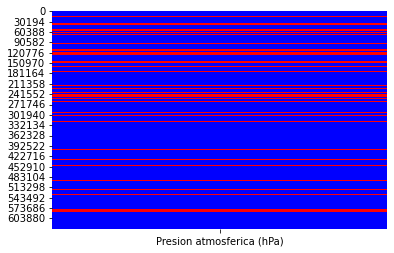

In [72]:
col = df.columns[21:22]
colours = ['#0000ff', '#ff0000'] 
sns.heatmap(df[col].isnull(), cmap=sns.color_palette(colours), cbar=False)

Esta magnitud empieza a medirse dos horas después de la activación de la primera boya.

In [73]:
print(df['Presion atmosferica (hPa)'].head(20))

0        NaN
1        NaN
2     1022.0
3     1023.0
4     1023.0
5     1023.0
6     1024.0
7     1024.0
8     1024.0
9     1023.0
10    1023.0
11    1023.0
12    1022.0
13    1022.0
14    1022.0
15    1022.0
16       NaN
17    1023.0
18    1023.0
19    1023.0
Name: Presion atmosferica (hPa), dtype: float64


In [74]:
df.loc[:1,'Presion atmosferica (hPa)']=-1

Los valores presentan poca variabilidad de una hora a otra, por lo que imputaremos los faltantes usando nuevamente **interpolación lineal**.

In [75]:
porcentaje_nan(df,'Presion atmosferica (hPa)')

16.5 %


In [76]:
df['Presion atmosferica (hPa)']=df['Presion atmosferica (hPa)'].interpolate('linear')

In [77]:
porcentaje_nan(df,'Presion atmosferica (hPa)')

0.0 %


### 3.1.5 Canales de obtención de datos

Los **canales de obtención de datos** son las columnas más sencillas de imputar al poder utilizar la **moda**.  Mostramos el porcentaje de *missing values* de los cuatro canales: 

In [78]:
variables=['Canal de obtencion de los datos','Canal de obtencion de los datos.1','Canal de obtencion de los datos.2','Canal de obtencion de los datos.3']
for var in variables:
    porcentaje_nan(df,var)

14.2 %
14.21 %
14.21 %
14.21 %


In [79]:
print(df['Canal de obtencion de los datos'].mode())
print(df['Canal de obtencion de los datos.1'].mode())
print(df['Canal de obtencion de los datos.2'].mode())
print(df['Canal de obtencion de los datos.3'].mode())

0    1.0
dtype: float64
0    1.0
dtype: float64
0    2.0
dtype: float64
0    2.0
dtype: float64


In [80]:
df['Canal de obtencion de los datos']=df['Canal de obtencion de los datos'].fillna(1)
df['Canal de obtencion de los datos.1']=df['Canal de obtencion de los datos.1'].fillna(1)
df['Canal de obtencion de los datos.2']=df['Canal de obtencion de los datos.2'].fillna(2)
df['Canal de obtencion de los datos.3']=df['Canal de obtencion de los datos.3'].fillna(2)

Comprobamos que se han imputado correctamente:

In [81]:
variables=['Canal de obtencion de los datos','Canal de obtencion de los datos.1','Canal de obtencion de los datos.2','Canal de obtencion de los datos.3']
for var in variables:
    porcentaje_nan(df,var)

0.0 %
0.0 %
0.0 %
0.0 %


### 3.1.6 Adecuación del formato

Antes de continuar cambiamos el tipo de dato de los atributos (*dtype*) según convenga.
 Los campos 'Boya' y todos los **canales de obtención** son de tipo **categoría** (enumerado), ya que solo pueden tomar un pequeño conjunto de valores.
Todas las magnitudes medidas son **números decimales** (*float*), excepto las que implican **direcciones** (oleaje, corriente, viento...) y la **presión atmosférica**, que son **enteros**. 


In [82]:
df=df.astype({'Boya':'category','Canal de obtencion de los datos':'category','Canal de obtencion de los datos.1':'category','Canal de obtencion de los datos.2':'category','Canal de obtencion de los datos.3':'category'})

In [83]:
df=df.astype({'Direcc. Media de Proced. (0=N,90=E)':int,'Direcc. de pico de proced. (0=N,90=E)':int, 'Direcc. Media de Proced. en el pico (grados)':int,'Dir. de prop. de la Corriente (0=N,90=E)':int,'Direc. de proced. del Viento (0=N,90=E)':int,'Presion atmosferica (hPa)':int})

In [84]:
print(df.dtypes)

Boya                                                  category
Fecha (GMT)                                     datetime64[ns]
Anyo                                                     int64
Mes                                                      int64
Dia                                                      int64
Hora                                                     int64
Altura Signif. del Oleaje (m)                          float64
Periodo Medio Tm02 (s)                                 float64
Periodo de Pico (s)                                    float64
Altura Maxima del Oleaje (m)                           float64
Periodo de la Ola Maxima (s)                           float64
Canal de obtencion de los datos                       category
Direcc. Media de Proced. (0=N,90=E)                      int32
Direcc. de pico de proced. (0=N,90=E)                    int32
Direcc. Media de Proced. en el pico (grados)             int32
Canal de obtencion de los datos.1                     c

## 3.2. Detección de outliers de magnitudes secundarias

En este paso se localizan aquellos valores que destacan entre los demás, bien por ser erróneos o por ser simplemente valores atípicos. Los que identifiquemos como datos no válidos o erróneos serán sustituidos por la media del valor inmediatamente **anterior** y **posterior**.

### 3.2.1 Oleaje.  Altura y periodo.

Representamos un **diagrama de caja** para las alturas y periodos del oleaje y los analizamos. En estos diagramas solo son visibles los puntos que sobresalen de los bigotes, los que se encuentran dentro de la caja delimitada por los percentiles no aparecen, por lo que son muy útiles para localizar valores atípicos.

#### 3.2.1.1 Altura máxima

<AxesSubplot:>

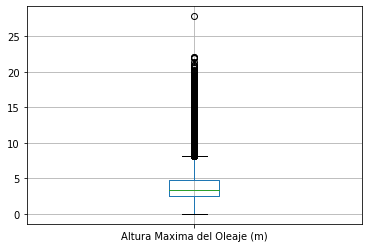

In [85]:
df.boxplot(column='Altura Maxima del Oleaje (m)')

Hay un valor que se aleja claramente de los demás, y que lógicamente es el máximo.

In [86]:
print(df['Altura Maxima del Oleaje (m)'].max())

27.81


No se trata de un error, sino que consta como la **ola más alta registrada jamás en aguas españolas**, después de la comprobación de este dato por parte de Puertos del Estado. Fue registrada por **Vilán-Sisargas**.

In [87]:
print(df.loc[df['Altura Maxima del Oleaje (m)']==27.81, ['Boya','Fecha (GMT)']])

                  Boya         Fecha (GMT)
359613  Vilan Sisargas 2014-01-06 12:00:00


DURANTE ESTADÍSTICA AVANZADA HEMOS ENCONTRADO DATOS ERRÓNEOS PARA LA ALTURA SIGNIFICANTE Y MÁXIMA. CONCRETAMENTE VALORES NULOS. LOS CORREGIMOS PARA LA NUEVA ACTIVIDAD.

In [88]:
print(df.loc[df['Altura Maxima del Oleaje (m)']==0., ['Boya','Fecha (GMT)']])

                   Boya         Fecha (GMT)
217994  Estaca de Bares 2021-06-01 17:00:00
258491   Vilan Sisargas 2002-06-25 02:00:00
508148    Cabo Silleiro 2007-07-22 07:00:00


In [92]:
df.loc[217989:217999:,'Altura Maxima del Oleaje (m)']

217989    2.59
217990    2.59
217991    2.59
217992    2.59
217993    2.59
217994    0.00
217995    2.69
217996    2.44
217997    2.53
217998    2.59
217999    2.38
Name: Altura Maxima del Oleaje (m), dtype: float64

In [93]:
df.loc[217994,'Altura Maxima del Oleaje (m)']=round((df.loc[217993,'Altura Maxima del Oleaje (m)']+df.loc[217995,'Altura Maxima del Oleaje (m)'])/2.,2)

In [95]:
df.loc[258486:258496 :,'Altura Maxima del Oleaje (m)']

258486    2.59
258487    2.59
258488    2.59
258489    2.59
258490    2.59
258491    0.00
258492    2.59
258493    2.59
258494    2.59
258495    2.59
258496    2.59
Name: Altura Maxima del Oleaje (m), dtype: float64

In [96]:
df.loc[258491,'Altura Maxima del Oleaje (m)']=round((df.loc[258486,'Altura Maxima del Oleaje (m)']+df.loc[258496 ,'Altura Maxima del Oleaje (m)'])/2.,2)

In [98]:
df.loc[508143:508153:,'Altura Maxima del Oleaje (m)']

508143    0.85
508144    0.74
508145    0.78
508146    0.62
508147    0.70
508148    0.00
508149    1.25
508150    1.75
508151    1.79
508152    2.34
508153    3.04
Name: Altura Maxima del Oleaje (m), dtype: float64

In [99]:
df.loc[508148,'Altura Maxima del Oleaje (m)']=round((df.loc[508143,'Altura Maxima del Oleaje (m)']+df.loc[508153 ,'Altura Maxima del Oleaje (m)'])/2.,2)

#### 3.2.1.2 Altura significante

<AxesSubplot:>

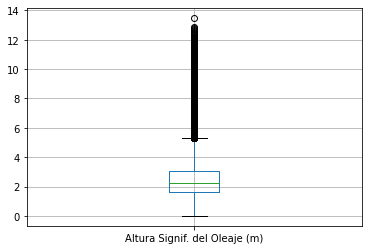

In [97]:
df.boxplot(column='Altura Signif. del Oleaje (m)')

Volvemos a detectar un valor atípico, ahora no tan distanciado de los demás, y que vuelve a tratarse del valor máximo.

In [98]:
print(df['Altura Signif. del Oleaje (m)'].max())

13.46


In [99]:
print(df.loc[df['Altura Signif. del Oleaje (m)']==13.46, ['Boya','Fecha (GMT)']])

                  Boya         Fecha (GMT)
316210  Vilan Sisargas 2009-01-24 01:00:00


Mostramos las instancias cercanas a ella, para ver si podemos confirmar la validez del dato.

In [100]:
print(df.loc[316205:316215,'Altura Signif. del Oleaje (m)'])

316205     7.57
316206     8.85
316207    10.17
316208    12.64
316209    12.01
316210    13.46
316211    12.15
316212    11.83
316213    11.10
316214    10.39
316215     9.83
Name: Altura Signif. del Oleaje (m), dtype: float64


No muestra un salto brusco respecto a los valores cercanos, por lo que consideramos este valor como **válido**.

In [102]:
print(df.loc[df['Altura Signif. del Oleaje (m)']==0., ['Boya','Fecha (GMT)']])

                   Boya         Fecha (GMT)
217994  Estaca de Bares 2021-06-01 17:00:00


In [103]:
print(df.loc[217989:217999,'Altura Signif. del Oleaje (m)'])

217989    1.69
217990    1.69
217991    1.69
217992    1.69
217993    1.69
217994    0.00
217995    1.88
217996    1.76
217997    1.64
217998    1.64
217999    1.64
Name: Altura Signif. del Oleaje (m), dtype: float64


In [104]:
df.loc[217994,'Altura Signif. del Oleaje (m)']=round((df.loc[217993,'Altura Signif. del Oleaje (m)']+df.loc[217995,'Altura Signif. del Oleaje (m)'])/2.,2)

#### 3.2.1.3 Periodo medio

<AxesSubplot:>

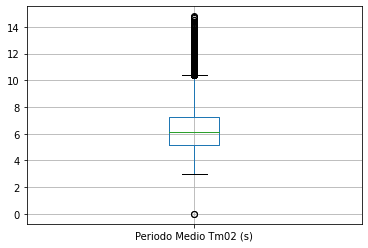

In [106]:
df.boxplot(column='Periodo Medio Tm02 (s)')

En este caso se presenta un valor nulo, lo que no tiene ningún sentido para un periodo, por lo que se trata claramente de un valor **erróneo**. 

In [107]:
print(df.loc[df['Periodo Medio Tm02 (s)']==0, ['Boya','Fecha (GMT)']])

                   Boya         Fecha (GMT)
217994  Estaca de Bares 2021-06-01 17:00:00
258491   Vilan Sisargas 2002-06-25 02:00:00


Al printearlos vemos que se trata en realidad de dos puntos. Los corregimos:

In [108]:
df.loc[217994,'Periodo Medio Tm02 (s)']=round((df.loc[217993,'Periodo Medio Tm02 (s)']+df.loc[217995,'Periodo Medio Tm02 (s)'])/2.,2)
df.loc[258491,'Periodo Medio Tm02 (s)']=round((df.loc[258490,'Periodo Medio Tm02 (s)']+df.loc[258492,'Periodo Medio Tm02 (s)'])/2.,2)

Comprobamos la corrección:

<AxesSubplot:>

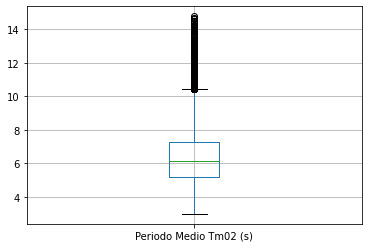

In [109]:
df.boxplot(column='Periodo Medio Tm02 (s)')

#### 3.2.1.4 Periodo de pico

<AxesSubplot:>

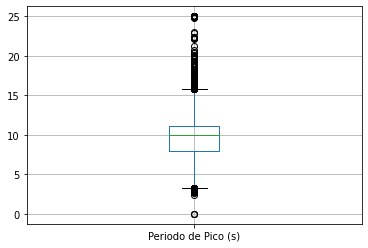

In [110]:
df.boxplot(column='Periodo de Pico (s)')

En este caso vemos un par de valores máximos, pero no tan alejados de los demás valores como en las magnitudes anteriores, lo que muestra que simplemente son valores fuera de rango. En cambio, volvemos a tener uno (o más) valores nulos **erróneos**.

In [111]:
print(df.loc[df['Periodo de Pico (s)']==0, ['Boya','Fecha (GMT)']])

                   Boya         Fecha (GMT)
217994  Estaca de Bares 2021-06-01 17:00:00
258491   Vilan Sisargas 2002-06-25 02:00:00
508148    Cabo Silleiro 2007-07-22 07:00:00


Los corregimos y comprobamos:

In [112]:
df.loc[217994,'Periodo de Pico (s)']=round((df.loc[217993,'Periodo de Pico (s)']+df.loc[217995,'Periodo de Pico (s)'])/2.,2)
df.loc[258491,'Periodo de Pico (s)']=round((df.loc[258490,'Periodo de Pico (s)']+df.loc[258492,'Periodo de Pico (s)'])/2.,2)
df.loc[508148,'Periodo de Pico (s)']=round((df.loc[508147,'Periodo de Pico (s)']+df.loc[508149,'Periodo de Pico (s)'])/2.,2)

<AxesSubplot:>

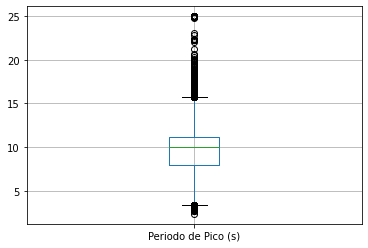

In [113]:
df.boxplot(column='Periodo de Pico (s)')

#### 3.2.1.5 Periodo de ola máxima

<AxesSubplot:>

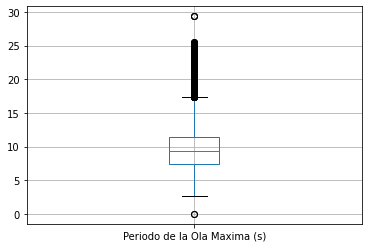

In [114]:
df.boxplot(column='Periodo de la Ola Maxima (s)')

Ahora tenemos un valor máximo bastante apartado y uno (o más) valores nulos que probablemente coincidan con las fechas ya vistas en los otros periodos. 

In [115]:
print(df['Periodo de la Ola Maxima (s)'].max())

29.37


Se tratan de tres puntos máximos. Observamos las instancias cercanas para determinar la validez:

In [116]:
print(df.loc[df['Periodo de la Ola Maxima (s)']==29.37, ['Boya','Fecha (GMT)']])

                   Boya         Fecha (GMT)
122828  Estaca de Bares 2010-07-24 11:00:00
329324   Vilan Sisargas 2010-07-24 11:00:00
534504    Cabo Silleiro 2010-07-24 11:00:00


In [117]:
print(df.loc[122823:122833,'Periodo de la Ola Maxima (s)'])
print(df.loc[329319:329329,'Periodo de la Ola Maxima (s)'])
print(df.loc[534495:534509,'Periodo de la Ola Maxima (s)'])

122823     6.52
122824     5.58
122825     5.71
122826     5.47
122827     5.05
122828    29.37
122829     5.11
122830     5.17
122831     4.55
122832     5.20
122833     4.15
Name: Periodo de la Ola Maxima (s), dtype: float64
329319     6.52
329320     5.58
329321     5.71
329322     5.47
329323     5.05
329324    29.37
329325     5.11
329326     5.17
329327     4.55
329328     5.20
329329     4.15
Name: Periodo de la Ola Maxima (s), dtype: float64
534495     5.61
534496     7.01
534497     7.72
534498     4.68
534499     6.52
534500     5.58
534501     5.71
534502     5.47
534503     5.05
534504    29.37
534505     5.11
534506     5.17
534507     4.55
534508     5.20
534509     4.15
Name: Periodo de la Ola Maxima (s), dtype: float64


Como los tres datos suponen un salto brusco respecto a las instancias cercanas, son trivialmente **erróneos**. Los corregimos:

In [118]:
df.loc[122828,'Periodo de la Ola Maxima (s)']=round((df.loc[122827,'Periodo de la Ola Maxima (s)']+df.loc[122829,'Periodo de la Ola Maxima (s)'])/2.,2)
df.loc[329324,'Periodo de la Ola Maxima (s)']=round((df.loc[329323,'Periodo de la Ola Maxima (s)']+df.loc[329325,'Periodo de la Ola Maxima (s)'])/2.,2)
df.loc[534504,'Periodo de la Ola Maxima (s)']=round((df.loc[534503,'Periodo de la Ola Maxima (s)']+df.loc[534505,'Periodo de la Ola Maxima (s)'])/2.,2)

Repetimos lo mismo para los valores nulos:

In [119]:
print(df.loc[df['Periodo de la Ola Maxima (s)']==0, ['Boya','Fecha (GMT)']])

                  Boya         Fecha (GMT)
258491  Vilan Sisargas 2002-06-25 02:00:00
508148   Cabo Silleiro 2007-07-22 07:00:00


In [120]:
df.loc[258491,'Periodo de la Ola Maxima (s)']=round((df.loc[258490,'Periodo de la Ola Maxima (s)']+df.loc[258492,'Periodo de la Ola Maxima (s)'])/2.,2)
df.loc[508148,'Periodo de la Ola Maxima (s)']=round((df.loc[508147,'Periodo de la Ola Maxima (s)']+df.loc[508149,'Periodo de la Ola Maxima (s)'])/2.,2)

Comprobamos:

<AxesSubplot:>

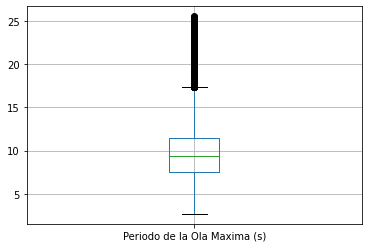

In [121]:
df.boxplot(column='Periodo de la Ola Maxima (s)')

### 3.2.2 Oleaje.  Dirección.

<AxesSubplot:>

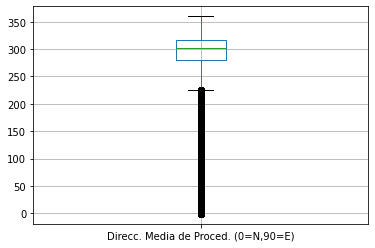

In [122]:
df.boxplot(column='Direcc. Media de Proced. (0=N,90=E)')

<AxesSubplot:>

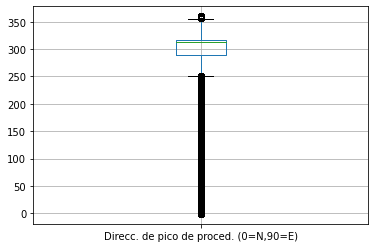

In [123]:
df.boxplot(column='Direcc. de pico de proced. (0=N,90=E)')

<AxesSubplot:>

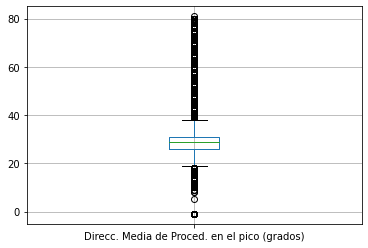

In [124]:
df.boxplot(column='Direcc. Media de Proced. en el pico (grados)')

**No hay ningún valor atípico en estas tres magnitudes**. Los valores aislados por debajo del 0 en la dirección media en el pico, se tratan de los **-1** que hemos introducido anteriormente. 

### 3.2.3 Corriente y viento. Velocidad y dirección.

#### 3.2.3.1 Velocidad de la corriente

<AxesSubplot:>

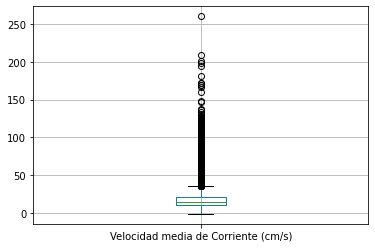

In [125]:
df.boxplot(column='Velocidad media de Corriente (cm/s)')

Hay un valor que destaca sobre los demás, el máximo. Comprobamos si es incorrecto, y de serlo, lo corregimos como en los apartados anteriores.

In [126]:
print(df['Velocidad media de Corriente (cm/s)'].max())

260.1


In [127]:
print(df.loc[df['Velocidad media de Corriente (cm/s)']==260.1, ['Boya','Fecha (GMT)']])

                 Boya         Fecha (GMT)
501570  Cabo Silleiro 2006-10-21 05:00:00


In [128]:
print(df.loc[501565:501575,'Velocidad media de Corriente (cm/s)'])

501565    168.7
501566    135.9
501567    172.2
501568    181.6
501569    172.2
501570    260.1
501571    201.5
501572    208.5
501573    198.0
501574    194.5
501575    169.9
Name: Velocidad media de Corriente (cm/s), dtype: float64


Aunque es dudoso, debido a que ahora el salto respecto al anterior y el posterior no es tan brusco, lo tomaremos como **incorrecto**.

In [129]:
df.loc[501570,'Velocidad media de Corriente (cm/s)']=round((df.loc[501569,'Velocidad media de Corriente (cm/s)']+df.loc[501571,'Velocidad media de Corriente (cm/s)'])/2.,2)

Comprobamos:

<AxesSubplot:>

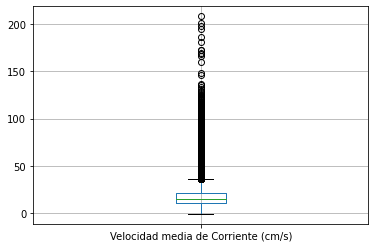

In [130]:
df.boxplot(column='Velocidad media de Corriente (cm/s)')

#### 3.2.3.2 Velocidad del viento

<AxesSubplot:>

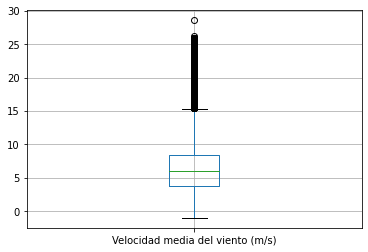

In [131]:
df.boxplot(column='Velocidad media del viento (m/s)')

Comprobamos la validez de ese valor máximo:

In [132]:
print(df['Velocidad media del viento (m/s)'].max())

28.6


In [133]:
print(df.loc[df['Velocidad media del viento (m/s)']==28.6, ['Boya','Fecha (GMT)']])

                  Boya         Fecha (GMT)
23753  Estaca de Bares 1999-04-05 08:00:00


In [134]:
print(df.loc[23748:23758,'Velocidad media del viento (m/s)'])

23748     1.9
23749     3.7
23750     3.6
23751     4.5
23752     4.5
23753    28.6
23754     4.3
23755     4.4
23756     3.3
23757     3.3
23758     4.3
Name: Velocidad media del viento (m/s), dtype: float64


Es claramente **erróneo**. Corregimos y comprobamos:

In [135]:
df.loc[23753,'Velocidad media del viento (m/s)']=round((df.loc[23752,'Velocidad media del viento (m/s)']+df.loc[23754,'Velocidad media del viento (m/s)'])/2.,2)

<AxesSubplot:>

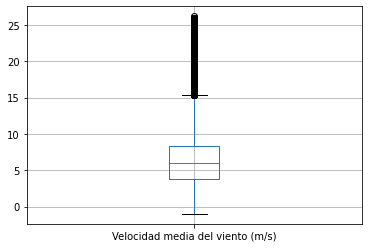

In [136]:
df.boxplot(column='Velocidad media del viento (m/s)')

#### 3.2.3.3 Direcciones del viento y la corriente

<AxesSubplot:>

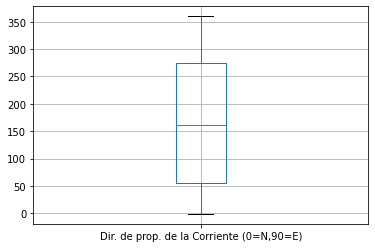

In [137]:
df.boxplot(column='Dir. de prop. de la Corriente (0=N,90=E)')

<AxesSubplot:>

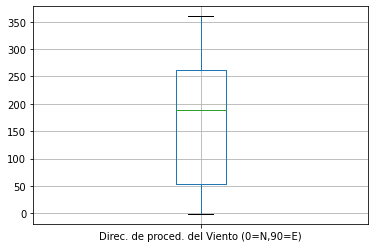

In [138]:
df.boxplot(column='Direc. de proced. del Viento (0=N,90=E)')

Para estas magnitudes no hay ningún valor atípico, de hecho ningún valor sobresale de los bigotes.

### 3.2.4 Presión atmosférica

<AxesSubplot:>

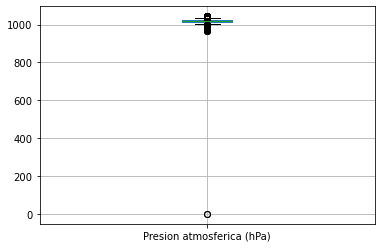

In [139]:
df.boxplot(column='Presion atmosferica (hPa)')

Este es el valor más fuera de rango de los vistos. 

In [140]:
print(df.loc[df['Presion atmosferica (hPa)']==0, ['Boya','Fecha (GMT)']])

Empty DataFrame
Columns: [Boya, Fecha (GMT)]
Index: []


In [141]:
print(df.loc[df['Presion atmosferica (hPa)']!=-1,'Presion atmosferica (hPa)'].min())

967


Tras estas comprobaciones podemos ver que en realidad no es un valor atípico, sino los **-1** que hemos introducido en algunos *missing values*.

### 3.2.5 Canales de obtención de datos

Para las **variables categóricas** es más adecuado el **diagrama de barras**.

<AxesSubplot:>

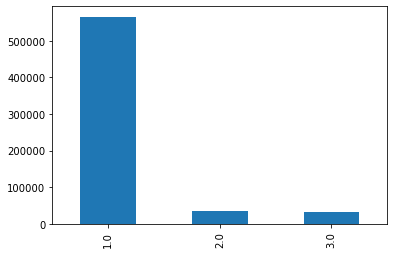

In [142]:
df['Canal de obtencion de los datos'].value_counts().plot.bar()

<AxesSubplot:>

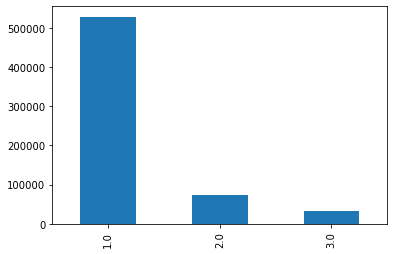

In [143]:
df['Canal de obtencion de los datos.1'].value_counts().plot.bar()

<AxesSubplot:>

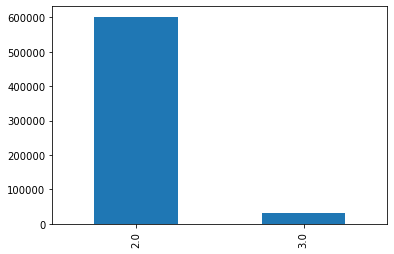

In [144]:
df['Canal de obtencion de los datos.2'].value_counts().plot.bar()

<AxesSubplot:>

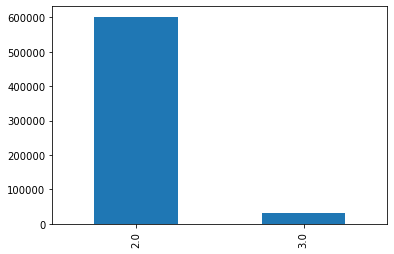

In [145]:
df['Canal de obtencion de los datos.3'].value_counts().plot.bar()

**No hay ningún valor atípico**. Los diagramas son razonables, pues las boyas cuentan con 3 canales de medida. De ellos se deduce que el 1 y 2 son los que captan más medidas.

## 4. Limpieza de las magnitudes de mayor interés

Antes de obtener las series **diarias** debemos tratar los datos aberrantes para las tres magnitudes. Los *missing values* serán completados sobre las series diarias mediante una red neuronal.

## 4.1. Datos aberrantes

En el caso de las magnitudes de interés no sustituiremos los **datos aberrantes** por la media del anterior y posterior, sino que los transformaremos en **missing values**, para completarlos posteriormente con los demás datos faltantes. Para localizarlos aplicaremos dos procesos:
* Definir unos límites máximo y mínimo, fuera de los cuales el dato es trivialmente **erróneo**.
* Estudiar los datos que se alejan de la **media** más de **4 desviaciones típicas** y comprobar si son **erróneos** o no.

### 4.1.1 Temperatura del aire

Teniendo en cuenta que el récord máximo de temperatura alcanzada en España es **47,4 ºC** (14 de agosto de 2021 en Córdoba), y el mínimo es **-35,6 ºC** (7 de enero de 2021 en los Picos de Europa), es razonable establecer estos como límites infranqueables. 

In [146]:
def datos_erroneos(variable,maxim,minim):
    df_erroneos=df[(df[variable]>=maxim)| (df[variable]<=minim)]
    return df_erroneos[['Boya','Fecha (GMT)', variable]]

In [147]:
print(datos_erroneos('Temperatura del Aire (celsius)',47.4,-35.6))

Empty DataFrame
Columns: [Boya, Fecha (GMT), Temperatura del Aire (celsius)]
Index: []


No se ha encontrado ningún valor aberrante por este método. Probemos ahora con el segundo paso:

In [148]:
def fuera_rango (variable):
    media=df[variable].mean()
    desv=df[variable].std()
    df_fuera_rango=df[(df[variable]>media+4.*desv)|(df[variable]<media-4.*desv)]
    return df_fuera_rango[['Boya','Fecha (GMT)', variable]]

In [149]:
print(fuera_rango('Temperatura del Aire (celsius)'))

                   Boya         Fecha (GMT)  Temperatura del Aire (celsius)
49986   Estaca de Bares 2002-04-02 09:00:00                             3.7
49987   Estaca de Bares 2002-04-02 10:00:00                             3.8
49989   Estaca de Bares 2002-04-02 12:00:00                             3.5
49993   Estaca de Bares 2002-04-02 16:00:00                             3.6
49994   Estaca de Bares 2002-04-02 17:00:00                             3.8
49995   Estaca de Bares 2002-04-02 18:00:00                             3.3
49996   Estaca de Bares 2002-04-02 19:00:00                             2.9
49997   Estaca de Bares 2002-04-02 20:00:00                             2.3
49998   Estaca de Bares 2002-04-02 21:00:00                             2.6
49999   Estaca de Bares 2002-04-02 22:00:00                             1.5
50000   Estaca de Bares 2002-04-02 23:00:00                             2.3
50001   Estaca de Bares 2002-04-03 00:00:00                             3.3
50002   Esta

Vemos que hay varios intervalos con valores fuera de rango:

 **1)** En Estaca de Bares del **2/4/2002** a las  **9** al **3/4/2002** a las **10** hay valores en torno a los **2** y **3 ºC**. Como dichos valores abarcan un día completo, se entiende que son valores válidos, y se trata simplemente de un **día especialmente frío**.
 
**2)** En Estaca de Bares el **7/10/2003** de **11** a **13 h** hay valores de **0,3 ºC**. Para estudiar su validez observamos los valores cercanos:

In [150]:
print(df.loc[63255:63267,'Temperatura del Aire (celsius)'])

63255    19.5
63256    19.5
63257    19.8
63258    19.5
63259     NaN
63260     0.3
63261     0.3
63262     0.3
63263     NaN
63264     NaN
63265    18.1
63266    18.4
63267    18.5
Name: Temperatura del Aire (celsius), dtype: float64


Se tratan de valores **erróneos** pues los valores más cercanos registrados rondan los **19 ºC**, e inmediatamente antes y despúes existen valores faltantes. Esto evidencia que hay un **fallo puntual** en la boya.

Los sustituimos entonces por *missing values*:

In [151]:
print(df.loc[63260:63262,'Temperatura del Aire (celsius)'])

63260    0.3
63261    0.3
63262    0.3
Name: Temperatura del Aire (celsius), dtype: float64


In [152]:
df.loc[63260:63262,'Temperatura del Aire (celsius)']=np.nan

In [153]:
print(df.loc[63260:63262,'Temperatura del Aire (celsius)'])

63260   NaN
63261   NaN
63262   NaN
Name: Temperatura del Aire (celsius), dtype: float64


**3)** En Estaca de Bares el **14/8/2004** a las **14** y **16 h** hay valores en torno a los **26 ºC**. Mostramos los valores cercanos:             

In [154]:
print(df.loc[70746:70756,'Temperatura del Aire (celsius)'])

70746    22.1
70747    23.1
70748    23.9
70749    24.5
70750    24.8
70751    26.4
70752    26.2
70753    26.7
70754    24.8
70755    24.0
70756    23.3
Name: Temperatura del Aire (celsius), dtype: float64


Se tratan de valores **válidos**, puesto que son similares a los cercanos.

**4)** En Estaca de Bares el **26/2/2005** a las **2 h** hay un valor de **3,9 ºC**. Observamos los cercanos:

In [155]:
print(df.loc[75438:75448,'Temperatura del Aire (celsius)'])

75438    6.9
75439    5.2
75440    4.5
75441    5.0
75442    7.1
75443    3.9
75444    5.8
75445    5.2
75446    6.4
75447    5.0
75448    6.4
Name: Temperatura del Aire (celsius), dtype: float64


Como no diverge excesivamente de los datos anterior y posterior lo tomaremos como **válido**.

**5**) En Estaca de Bares el **29/1/2006** a las **4 h** hay un valor de **3,6 ºC**. Mostramos los cercanos:

In [156]:
print(df.loc[83528:83538,'Temperatura del Aire (celsius)'])

83528    7.0
83529    7.0
83530    6.7
83531    6.8
83532    6.0
83533    3.6
83534    6.1
83535    7.3
83536    7.4
83537    8.0
83538    8.4
Name: Temperatura del Aire (celsius), dtype: float64


De nuevo al no diverger demasiado de los demás, lo tomamos como **válido**.

**6)** En Cabo Silleiro el **3/8/2003** a la **1** hay un valor de **26,8 ºC**. Comprobamos los cercanos:

In [157]:
print(df.loc[473361:473371,'Temperatura del Aire (celsius)'])

473361    20.9
473362    20.3
473363    19.6
473364    19.7
473365    21.3
473366    26.8
473367    24.1
473368    22.6
473369    21.7
473370    22.5
473371    21.2
Name: Temperatura del Aire (celsius), dtype: float64


Dada la similitud con los cercanos es un **valor válido**, que se corresponde con el **máximo de temperatura del aire** de las 3 boyas.

In [158]:
print(df['Temperatura del Aire (celsius)'].max())

26.8


**7)** En Cabo Silleiro el **4/4/2005** de **3** a **9 h** existen valores en torno los **3 ºC**. Mostramos los valores cercanos:  
        

In [159]:
print(df.loc[488003:488019,'Temperatura del Aire (celsius)'])

488003    4.6
488004    4.5
488005    4.6
488006    4.5
488007    4.0
488008    3.9
488009    3.7
488010    3.7
488011    3.7
488012    3.4
488013    3.3
488014    3.0
488015    NaN
488016    NaN
488017    NaN
488018    NaN
488019    NaN
Name: Temperatura del Aire (celsius), dtype: float64


A pesar de que los siguientes valores no fueron registrados, viendo la tendencia de los anteriores, podemos considerarlos como **válidos**.

**8)** En Cabo Silleiro el **4/11/2021** a las **12 h** se registra un valor nulo de la temperatura. Aunque lo más probable es que sea erróneo, comprobaremos igualmente los cercanos.

In [160]:
print(df.loc[633404:633414,'Temperatura del Aire (celsius)'])

633404    14.84
633405    14.69
633406    14.69
633407      NaN
633408      NaN
633409     0.00
633410      NaN
633411    15.00
633412    15.47
633413    15.94
633414    15.78
Name: Temperatura del Aire (celsius), dtype: float64


Hemos confirmado que es **erróneo**, pues los valores más cercanos registrados rondan los **15 ºC**. Lo convertimos en *missing value*.

In [161]:
df.loc[633409,'Temperatura del Aire (celsius)']=np.nan

In [162]:
print(df.loc[633409,'Temperatura del Aire (celsius)'])

nan


Graficamos el **diagrama de caja**, para confirmar que no hayamos olvidado algún dato aberrante y mostramos los parámetros estadísticos.

<AxesSubplot:>

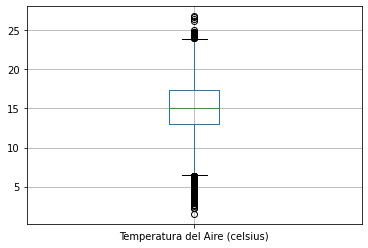

In [163]:
df.boxplot(column='Temperatura del Aire (celsius)')

In [164]:
print(df['Temperatura del Aire (celsius)'].describe())

count    509989.000000
mean         15.107849
std           2.783668
min           1.500000
25%          13.000000
50%          15.000000
75%          17.400000
max          26.800000
Name: Temperatura del Aire (celsius), dtype: float64


### 4.1.2 Temperatura del agua

Para las aguas de la costa gallega atlántica unos límites razonables son **-5 ºC** y **25 ºC**. Todos los valores que no se encuentren en ese rango serán **incorrectos**.

In [165]:
print(datos_erroneos('Temperatura del Agua (celsius)',25,-5))

Empty DataFrame
Columns: [Boya, Fecha (GMT), Temperatura del Agua (celsius)]
Index: []


No hay ningún valor que sobrepase esos límites. Probamos con el método de la desviación media.

In [166]:
print(fuera_rango('Temperatura del Agua (celsius)'))

Empty DataFrame
Columns: [Boya, Fecha (GMT), Temperatura del Agua (celsius)]
Index: []


Tampoco se encuentran valores, pero si graficamos el diagrama de caja vemos un claro dato mínimo **erróneo**. Lo corregimos.

<AxesSubplot:>

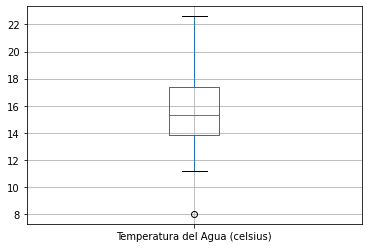

In [167]:
df.boxplot(column='Temperatura del Agua (celsius)')

In [168]:
print(df['Temperatura del Agua (celsius)'].min())

8.0


In [169]:
print(df.loc[df['Temperatura del Agua (celsius)']==8,['Boya','Fecha (GMT)','Temperatura del Agua (celsius)']])

                  Boya         Fecha (GMT)  Temperatura del Agua (celsius)
423405  Vilan Sisargas 2021-04-17 12:00:00                             8.0


In [170]:
df.loc[423405,'Temperatura del Agua (celsius)']=np.nan

Comprobamos y mostramos los datos estadísticos:

<AxesSubplot:>

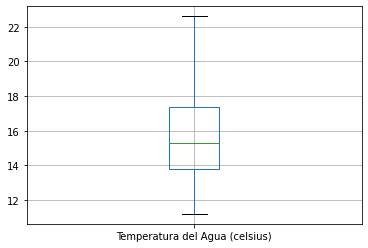

In [171]:
df.boxplot(column='Temperatura del Agua (celsius)')

In [172]:
print(df['Temperatura del Agua (celsius)'].describe())

count    443619.000000
mean         15.687413
std           2.273243
min          11.200000
25%          13.800000
50%          15.300000
75%          17.400000
max          22.610000
Name: Temperatura del Agua (celsius), dtype: float64


Vemos finalmente en que boya y fecha se registra la **máxima**:

In [173]:
print(df.loc[df['Temperatura del Agua (celsius)']==22.61,['Boya','Fecha (GMT)','Temperatura del Agua (celsius)']])


                   Boya         Fecha (GMT)  Temperatura del Agua (celsius)
210889  Estaca de Bares 2020-08-09 16:00:00                           22.61


### 4.1.3 Salinidad

Sabiendo que la salinidad es de **12 psu** en el Mar Caspio (salobre) y de **40 psu** en el Mar Rojo (mar bastante salino), aplicamos estos límites extremos:

In [174]:
print(datos_erroneos('Salinidad (psu)',40,12))

Empty DataFrame
Columns: [Boya, Fecha (GMT), Salinidad (psu)]
Index: []


No hay datos que sobrepasan los límites. Aplicamos el segundo método:

In [175]:
print(fuera_rango('Salinidad (psu)'))

                   Boya         Fecha (GMT)  Salinidad (psu)
132051  Estaca de Bares 2011-08-12 18:00:00            36.52
172774  Estaca de Bares 2016-04-04 13:00:00            34.66
172785  Estaca de Bares 2016-04-05 00:00:00            34.76
205991  Estaca de Bares 2020-01-18 14:00:00            34.62
205992  Estaca de Bares 2020-01-18 15:00:00            34.68
...                 ...                 ...              ...
626962    Cabo Silleiro 2021-02-08 21:00:00            34.53
626963    Cabo Silleiro 2021-02-08 22:00:00            34.47
626964    Cabo Silleiro 2021-02-08 23:00:00            34.52
626965    Cabo Silleiro 2021-02-09 00:00:00            34.68
626966    Cabo Silleiro 2021-02-09 01:00:00            34.76

[2432 rows x 3 columns]


Aparecen **2432** valores fuera de rango.

<AxesSubplot:>

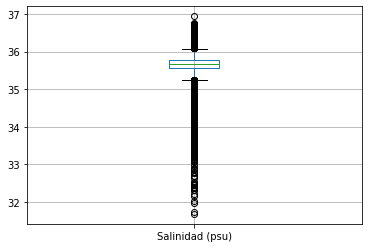

In [176]:
df.boxplot(column='Salinidad (psu)')

En el diagrama de caja vemos que efectivamente muchos valores sobresalen de los bigotes, pero no hay ninguno que se aleje excesivamente de los demás, por lo que se entiende que son todos **válidos**.

In [177]:
print(df['Salinidad (psu)'].describe())

count    347660.000000
mean         35.658319
std           0.212372
min          31.680000
25%          35.560000
50%          35.670000
75%          35.770000
max          36.940000
Name: Salinidad (psu), dtype: float64


El motivo de que existan tantos datos fuera de rango es la pequeña desviación típica, debida a la naturaleza tan **estable** de esta magnitud (muy poco fluctuante).

## 4.2. Missing values

Para obtener una idea de los *missing values*, graficamos las series horarias para las tres magnitudes: primero con las boyas por separado, y después en conjunto, desde la fecha de activación de la última boya (6/7/1998 20:00). 

In [178]:
CaboSilleiro=df[df['Boya']=='Cabo Silleiro']
CaboSilleiro.index=CaboSilleiro['Fecha (GMT)']
EstacaBares=df[df['Boya']=='Estaca de Bares']
EstacaBares.index=EstacaBares['Fecha (GMT)']
VilanSisargas=df[df['Boya']=='Vilan Sisargas']
VilanSisargas.index=VilanSisargas['Fecha (GMT)']

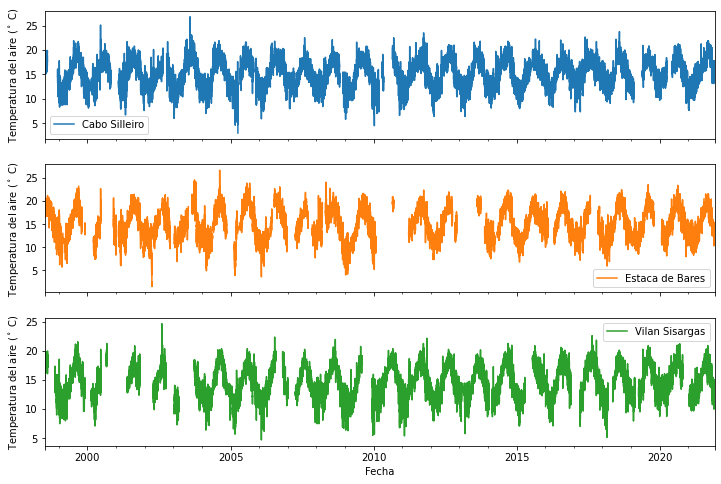

In [179]:
TempAire=pd.DataFrame()
TempAire['Cabo Silleiro']=CaboSilleiro['Temperatura del Aire (celsius)']
TempAire['Estaca de Bares']=EstacaBares['Temperatura del Aire (celsius)']
TempAire['Vilan Sisargas']=VilanSisargas['Temperatura del Aire (celsius)']
TempAire.loc['1998-7-6 20':'2021-12-1 23'].plot(subplots=True, figsize=(12,8),xlabel='Fecha',ylabel='Temperatura del aire ($^\circ$ C)')
plt.legend(loc='best')

<AxesSubplot:xlabel='Fecha', ylabel='Temperatura del aire ($^\\circ$ C)'>

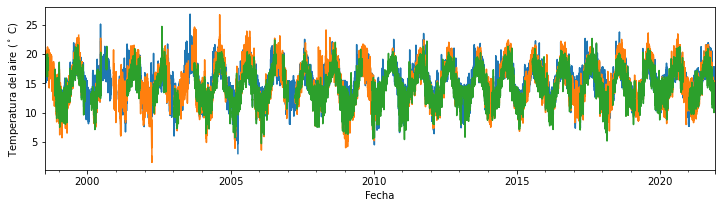

In [180]:
CaboSilleiro.loc['1998-7-6 20':'2021-12-1 23','Temperatura del Aire (celsius)'].plot(xlabel='Fecha',ylabel='Temperatura del aire ($^\circ$ C)',figsize=(12,3))
EstacaBares.loc['1998-7-6 20':'2021-12-1 23','Temperatura del Aire (celsius)'].plot(xlabel='Fecha',ylabel='Temperatura del aire ($^\circ$ C)')
VilanSisargas.loc['1998-7-6 20':'2021-12-1 23','Temperatura del Aire (celsius)'].plot(xlabel='Fecha',ylabel='Temperatura del aire ($^\circ$ C)')

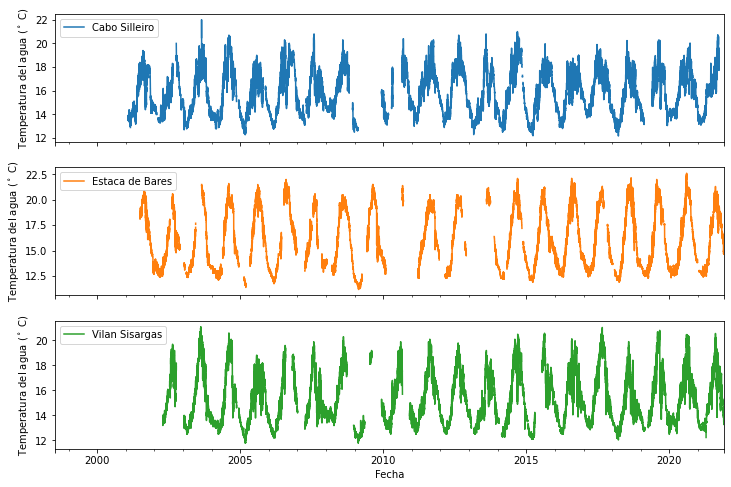

In [181]:
TempAgua=pd.DataFrame()
TempAgua['Cabo Silleiro']=CaboSilleiro['Temperatura del Agua (celsius)']
TempAgua['Estaca de Bares']=EstacaBares['Temperatura del Agua (celsius)']
TempAgua['Vilan Sisargas']=VilanSisargas['Temperatura del Agua (celsius)']
TempAgua.loc['1998-7-6 20':'2021-12-1 23'].plot(subplots=True, figsize=(12,8),xlabel='Fecha',ylabel='Temperatura del agua ($^\circ$ C)')
plt.legend(loc='best')

<AxesSubplot:xlabel='Fecha', ylabel='Temperatura del agua ($^\\circ$ C)'>

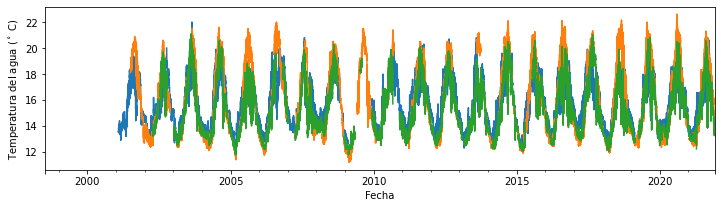

In [182]:
CaboSilleiro.loc['1998-7-6 20':'2021-12-1 23','Temperatura del Agua (celsius)'].plot(xlabel='Fecha',ylabel='Temperatura del agua ($^\circ$ C)',figsize=(12,3))
EstacaBares.loc['1998-7-6 20':'2021-12-1 23','Temperatura del Agua (celsius)'].plot(xlabel='Fecha',ylabel='Temperatura del agua ($^\circ$ C)')
VilanSisargas.loc['1998-7-6 20':'2021-12-1 23','Temperatura del Agua (celsius)'].plot(xlabel='Fecha',ylabel='Temperatura del agua ($^\circ$ C)')

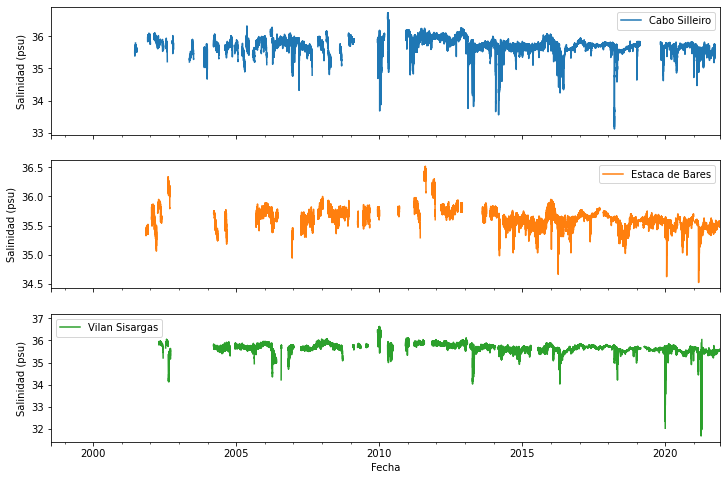

In [183]:
Salinidad=pd.DataFrame()
Salinidad['Cabo Silleiro']=CaboSilleiro['Salinidad (psu)']
Salinidad['Estaca de Bares']=EstacaBares['Salinidad (psu)']
Salinidad['Vilan Sisargas']=VilanSisargas['Salinidad (psu)']
Salinidad.loc['1998-7-6 20':'2021-12-1 23'].plot(subplots=True, figsize=(12,8),xlabel='Fecha',ylabel='Salinidad (psu)')
plt.legend(loc='best')

<AxesSubplot:xlabel='Fecha', ylabel='Salinidad (psu)'>

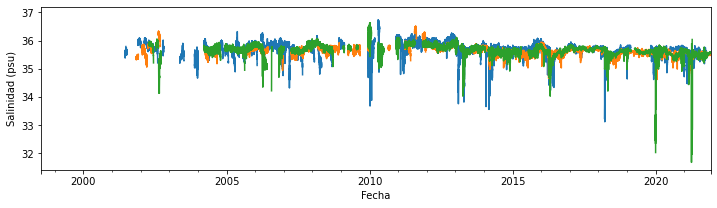

In [184]:
CaboSilleiro.loc['1998-7-6 20':'2021-12-1 23','Salinidad (psu)'].plot(xlabel='Fecha',ylabel='Salinidad (psu)',figsize=(12,3))
EstacaBares.loc['1998-7-6 20':'2021-12-1 23','Salinidad (psu)'].plot(xlabel='Fecha',ylabel='Salinidad (psu)')
VilanSisargas.loc['1998-7-6 20':'2021-12-1 23','Salinidad (psu)'].plot(xlabel='Fecha',ylabel='Salinidad (psu)')

De las gráficas se deduce que la **salinidad** es la que cuenta con más valores faltantes. 

*Missing values* conjuntos:

In [185]:
porcentaje_nan (df,'Temperatura del Aire (celsius)')
porcentaje_nan (df,'Temperatura del Agua (celsius)')
porcentaje_nan (df,'Salinidad (psu)')

19.57 %
30.04 %
45.17 %


*Missing values* de cada boya:

In [186]:
porcentaje_nan (CaboSilleiro,'Temperatura del Aire (celsius)')
porcentaje_nan (CaboSilleiro,'Temperatura del Agua (celsius)')
porcentaje_nan (CaboSilleiro,'Salinidad (psu)')

10.76 %
22.12 %
40.28 %


In [187]:
porcentaje_nan (EstacaBares,'Temperatura del Aire (celsius)')
porcentaje_nan (EstacaBares,'Temperatura del Agua (celsius)')
porcentaje_nan (EstacaBares,'Salinidad (psu)')

25.82 %
38.69 %
54.39 %


In [188]:
porcentaje_nan (VilanSisargas,'Temperatura del Aire (celsius)')
porcentaje_nan (VilanSisargas,'Temperatura del Agua (celsius)')
porcentaje_nan (VilanSisargas,'Salinidad (psu)')

21.59 %
28.59 %
40.1 %


Además en las gráficas superpuestas se manifiesta la **correlación** entre las series de las tres boyas, que nos permitirá completar unas a partir de otras con la **red neuronal**.

ESTADIIIIIISTICAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [22]:
df.to_csv("Datos_preprocesados.csv",sep='\t',na_rep='NaN')

NameError: name 'df' is not defined

In [2]:
df=pd.read_csv("Datos_preprocesados.csv",sep='\t', index_col=0, header=0, parse_dates=['Fecha (GMT)'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634069 entries, 0 to 634068
Data columns (total 26 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Boya                                          634069 non-null  object        
 1   Fecha (GMT)                                   634069 non-null  datetime64[ns]
 2   Anyo                                          634069 non-null  int64         
 3   Mes                                           634069 non-null  int64         
 4   Dia                                           634069 non-null  int64         
 5   Hora                                          634069 non-null  int64         
 6   Altura Signif. del Oleaje (m)                 634069 non-null  float64       
 7   Periodo Medio Tm02 (s)                        634069 non-null  float64       
 8   Periodo de Pico (s)                           634069 n

In [31]:
df.insert(26,'Binaria',1)

In [33]:
df['Binaria'].head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Binaria, dtype: int64

<AxesSubplot:>

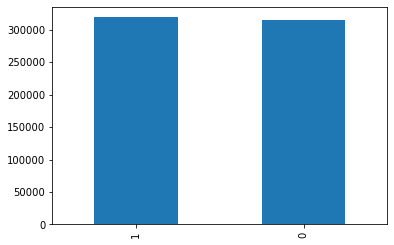

In [40]:
df['Binaria'].value_counts().plot.bar()

In [39]:
df.loc[(df['Mes']==1)|(df['Mes']==2)|(df['Mes']==3)|(df['Mes']==10)|(df['Mes']==11)|(df['Mes']==12),'Binaria']=0

In [41]:
df.to_csv("Datos_preprocesados_2.csv",sep='\t',na_rep='NaN')

In [5]:
df=pd.read_csv("Datos_preprocesados_2.csv",sep='\t', index_col=0, header=0, parse_dates=['Fecha (GMT)'])

In [6]:
df.loc[df['Presion atmosferica (hPa)']==-1, 'Presion atmosferica (hPa)']=df['Presion atmosferica (hPa)'].mean()

In [7]:
df.to_csv("Datos_preprocesados_2.csv",sep='\t',na_rep='NaN')

In [6]:
df_new=pd.DataFrame()

In [22]:
df_new2=pd.DataFrame()

In [19]:
df_new['Temperatura']=df.loc[df['Temperatura del Aire (celsius)'].notna(),'Temperatura del Aire (celsius)']

In [9]:
df_new['Binaria']=df.loc[df['Temperatura del Aire (celsius)'].notna(),'Binaria']

In [23]:
df_new2['Temperatura']=df.loc[df['Temperatura del Agua (celsius)'].notna(),'Temperatura del Agua (celsius)']

In [24]:
df_new2['Binaria']=df.loc[df['Temperatura del Agua (celsius)'].notna(),'Binaria']

In [13]:
df_new.to_csv("Datos_logistica.csv",sep='\t',na_rep='NaN')

In [3]:
df=pd.read_csv("Datos_logistica.csv",sep='\t', index_col=0, header=0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509989 entries, 4 to 633995
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperatura  509989 non-null  float64
 1   Binaria      509989 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 11.7 MB


In [25]:
df_new2.to_csv("Datos_logistica_2.csv",sep='\t',na_rep='NaN')

In [32]:
df['Temperatura del Agua (celsius)'].mean()

15.687413027847146

# 5. Cálculo de las medias diarias

Nuestro **objetivo** es **completar las series temporales** de estas tres magnitudes (**temperatura del aire**, **temperatura del agua** y **salinidad**), para poder trabajar con ellas a posteriori. Esto lo realizaremos sobre las **series diarias** con la ayuda de una **red neuronal**. Pero antes, debemos obtener las series **diarias** a partir de las **horarias**.
Para eso seguiremos el siguiente proceso:
* Para la **temperatura del aire**, recorremos día a día: si para un día hay más de **8** valores faltantes, la media diaria se definirá como NaN, pues la ausencia de un tercio de los valores puede suponer un valor poco fiel a la realidad; si en cambio hay menos de **8** valores faltantes se calculará la media para ese día con los valores completos.

* Para la **temperatura del agua** y la **salinidad** el procedimiento es el mismo, pero debido a la naturaleza de cada magnitud se tomarán como límite de datos faltantes diarios **12** y **16** respectivamente. 

Creamos las columnas para las medias diarias de las tres magnitudes, por ahora con todos los datos NaN:

In [184]:
df['Temperatura media del Aire (celsius)']=np.nan
df['Temperatura media del Agua (celsius)']=np.nan
df['Salinidad media (psu)']=np.nan

Obtenemos las fechas del **primer registro** de las tres magnitudes para las tres boyas, para evitar recorrer la totalidad de fechas:

**Estaca de Bares:**

In [185]:
df_estaca=df[(df['Boya']=='Estaca de Bares') & (df['Temperatura del Aire (celsius)'].notna())]
print('Primera medida de la temperatura del aire en Estaca de Bares:',df_estaca['Fecha (GMT)'].head(1))
df_estaca_2=df[(df['Boya']=='Estaca de Bares') & (df['Temperatura del Agua (celsius)'].notna())]
print('Primera medida de la temperatura del agua en Estaca de Bares:',df_estaca_2['Fecha (GMT)'].head(1))
df_estaca_3=df[(df['Boya']=='Estaca de Bares') & (df['Salinidad (psu)'].notna())]
print('Primera medida de la salinidad en Estaca de Bares:',df_estaca_3['Fecha (GMT)'].head(1))

Primera medida de la temperatura del aire en Estaca de Bares: 4   1996-07-19 19:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la temperatura del agua en Estaca de Bares: 43436   2001-07-03 11:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la salinidad en Estaca de Bares: 46416   2001-11-04 15:00:00
Name: Fecha (GMT), dtype: datetime64[ns]


**Vilán-Sisargas:**

In [186]:
df_vilan=df[(df['Boya']=='Vilan Sisargas') & (df['Temperatura del Aire (celsius)'].notna())]
print('Primera medida de la temperatura del aire en Vilán-Sisargas:',df_vilan['Fecha (GMT)'].head(1))
df_vilan_2=df[(df['Boya']=='Vilan Sisargas') & (df['Temperatura del Agua (celsius)'].notna())]
print('Primera medida de la temperatura del agua en Vilán-Sisargas:',df_vilan_2['Fecha (GMT)'].head(1))
df_vilan_3=df[(df['Boya']=='Vilan Sisargas') & (df['Salinidad (psu)'].notna())]
print('Primera medida de la salinidad en Vilán-Sisargas:',df_vilan_3['Fecha (GMT)'].head(1))

Primera medida de la temperatura del aire en Vilán-Sisargas: 222393   1998-05-13
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la temperatura del agua en Vilán-Sisargas: 256877   2002-04-18 20:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la salinidad en Vilán-Sisargas: 256877   2002-04-18 20:00:00
Name: Fecha (GMT), dtype: datetime64[ns]


**Cabo Silleiro:**

In [187]:
df_silleiro=df[(df['Boya']=='Cabo Silleiro') & (df['Temperatura del Aire (celsius)'].notna())]
print('Primera medida de la temperatura del aire en Cabo Silleiro:',df_silleiro['Fecha (GMT)'].head(1))
df_silleiro_2=df[(df['Boya']=='Cabo Silleiro') & (df['Temperatura del Agua (celsius)'].notna())]
print('Primera medida de la temperatura del agua en Cabo Silleiro:',df_silleiro_2['Fecha (GMT)'].head(1))
df_silleiro_3=df[(df['Boya']=='Cabo Silleiro') & (df['Salinidad (psu)'].notna())]
print('Primera medida de la salinidad en Cabo Silleiro:',df_silleiro_3['Fecha (GMT)'].head(1))

Primera medida de la temperatura del aire en Cabo Silleiro: 428889   1998-07-06 20:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la temperatura del agua en Cabo Silleiro: 451445   2001-01-31 16:00:00
Name: Fecha (GMT), dtype: datetime64[ns]
Primera medida de la salinidad en Cabo Silleiro: 454669   2001-06-15
Name: Fecha (GMT), dtype: datetime64[ns]


In [188]:
#Funcion que crea una lista de fechas entre una inicial y final
def recorrer_dias (fecha_inicio,fecha_fin):
    lista=[fecha_inicio+dt.timedelta(days=d) for d in range((fecha_fin-fecha_inicio).days+1)]
    return lista

In [189]:
#Funcion que calcula la media diaria de una magnitud a partir de los datos horarios de ese dia
def media_diaria (boya, variable, anyo, mes, dia, n):
    df_media=df[(df['Boya']==boya) & (df['Anyo']==anyo) & (df['Mes']== mes) & (df['Dia']==dia)]
    no_null=24-n
    if df_media[variable].count()>=no_null:
                media=df_media[variable].mean()
                return round(media,2)
        

In [190]:
#Funcion que introduce las medias diarias calculadas en las columnas de las medias 
def insert_media_diaria (boya, fecha_inicio, fecha_fin, variable, media_variable, n):
    lista_fechas=recorrer_dias(fecha_inicio,fecha_fin)
    i=0
    for fecha in lista_fechas:
        print(i)#Para ver la progresion de la ejecucion
        anyo=fecha.year
        mes=fecha.month
        dia=fecha.day
        df.loc[(df['Boya']==boya) & (df['Anyo']==anyo) & (df['Mes']== mes) & (df['Dia']==dia),media_variable]=media_diaria(boya, variable, anyo, mes, dia, n)
        i+=1

Obtenemos las **series diarias**:

<font color='red'>LAS SIGUIENTES EJECUCIONES TARDAN UNOS MINUTOS. SE ADJUNTA EN LA ENTREGA EL ARCHIVO RESULTANTE, "Datos_final.csv".</font> 

In [ ]:
insert_media_diaria ('Estaca de Bares', dt.datetime(1996,7,19), dt.datetime(2021,12,1), 'Temperatura del Aire (celsius)','Temperatura media del Aire (celsius)',5)
insert_media_diaria ('Estaca de Bares', dt.datetime(2001,7,3), dt.datetime(2021,12,1), 'Temperatura del Agua (celsius)','Temperatura media del Agua (celsius)',12)
insert_media_diaria ('Estaca de Bares', dt.datetime(2001,11,4), dt.datetime(2021,12,1), 'Salinidad (psu)','Salinidad media (psu)',16)

In [ ]:
insert_media_diaria ('Vilan Sisargas', dt.datetime(1998,5,13), dt.datetime(2021,12,1),'Temperatura del Aire (celsius)','Temperatura media del Aire (celsius)',5)
insert_media_diaria ('Vilan Sisargas', dt.datetime(2002,4,18), dt.datetime(2021,12,1), 'Temperatura del Agua (celsius)','Temperatura media del Agua (celsius)',12)
insert_media_diaria ('Vilan Sisargas', dt.datetime(2002,4,18), dt.datetime(2021,12,1), 'Salinidad (psu)','Salinidad media (psu)',16)

In [ ]:
insert_media_diaria ('Cabo Silleiro', dt.datetime(1998,7,6), dt.datetime(2021,12,1), 'Temperatura del Aire (celsius)','Temperatura media del Aire (celsius)',5)
insert_media_diaria ('Cabo Silleiro', dt.datetime(2001,1,31), dt.datetime(2021,12,1),  'Temperatura del Agua (celsius)','Temperatura media del Agua (celsius)',12)
insert_media_diaria ('Cabo Silleiro', dt.datetime(2001,6,15), dt.datetime(2021,12,1), 'Salinidad (psu)','Salinidad media (psu)', 16)

In [79]:
df.to_csv("Datos_final.csv",sep='\t',na_rep='NaN')

In [192]:
df=pd.read_csv('Datos_final.csv',sep='\t', index_col=0, header=0, parse_dates=['Fecha (GMT)'])

Comprobamos que las columnas con las medias diarias contienen ahora datos:

In [193]:
print(df['Temperatura media del Aire (celsius)'].count())

507696


In [194]:
print(df['Temperatura media del Agua (celsius)'].count())

445440


In [195]:
print(df['Salinidad media (psu)'].count())

349680


Al igual que hicimos con las series horarias, graficamos las series diarias calculadas:

In [196]:
CaboSilleiro=df[df['Boya']=='Cabo Silleiro']
CaboSilleiro.index=CaboSilleiro['Fecha (GMT)']
EstacaBares=df[df['Boya']=='Estaca de Bares']
EstacaBares.index=EstacaBares['Fecha (GMT)']
VilanSisargas=df[df['Boya']=='Vilan Sisargas']
VilanSisargas.index=VilanSisargas['Fecha (GMT)']

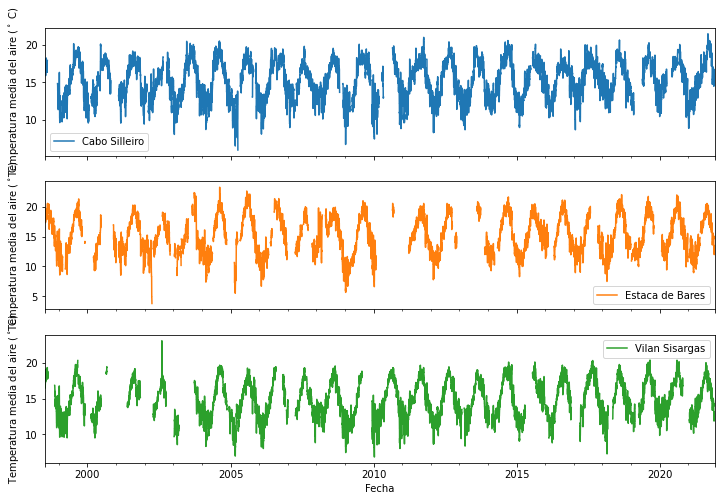

In [197]:
TempAire_media=pd.DataFrame()
TempAire_media['Cabo Silleiro']=CaboSilleiro['Temperatura media del Aire (celsius)']
TempAire_media['Estaca de Bares']=EstacaBares['Temperatura media del Aire (celsius)']
TempAire_media['Vilan Sisargas']=VilanSisargas['Temperatura media del Aire (celsius)']
TempAire_media.loc['1998-7-6 20':'2021-12-1 23'].plot(subplots=True, figsize=(12,8),xlabel='Fecha',ylabel='Temperatura media del aire ($^\circ$ C)')
plt.legend(loc='best')

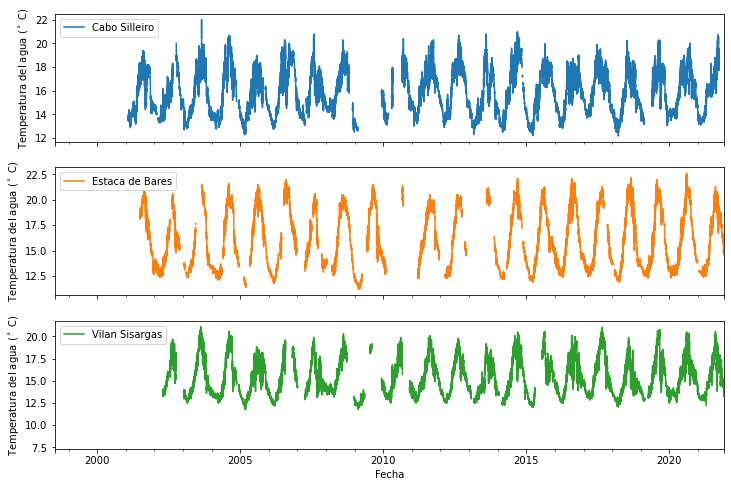

In [198]:
TempAgua_media=pd.DataFrame()
TempAgua_media['Cabo Silleiro']=CaboSilleiro['Temperatura del Agua (celsius)']
TempAgua_media['Estaca de Bares']=EstacaBares['Temperatura del Agua (celsius)']
TempAgua_media['Vilan Sisargas']=VilanSisargas['Temperatura del Agua (celsius)']
TempAgua_media.loc['1998-7-6 20':'2021-12-1 23'].plot(subplots=True, figsize=(12,8),xlabel='Fecha',ylabel='Temperatura del agua ($^\circ$ C)')
plt.legend(loc='best')

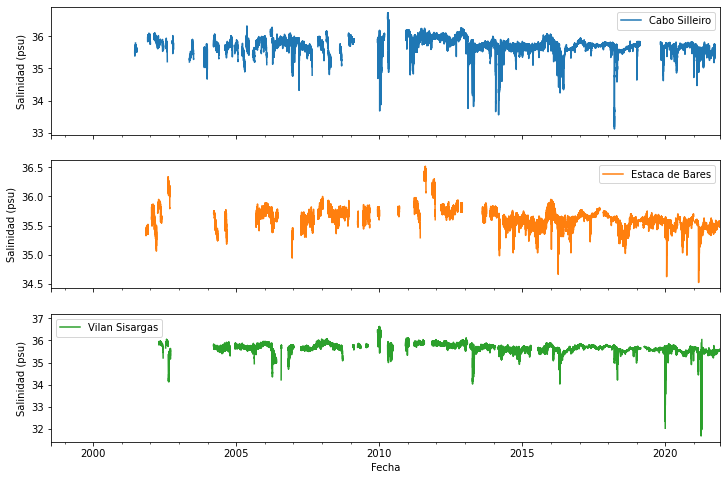

In [199]:
Salinidad_media=pd.DataFrame()
Salinidad_media['Cabo Silleiro']=CaboSilleiro['Salinidad (psu)']
Salinidad_media['Estaca de Bares']=EstacaBares['Salinidad (psu)']
Salinidad_media['Vilan Sisargas']=VilanSisargas['Salinidad (psu)']
Salinidad_media.loc['1998-7-6 20':'2021-12-1 23'].plot(subplots=True, figsize=(12,8),xlabel='Fecha',ylabel='Salinidad (psu)')
plt.legend(loc='best')

Y finalmente mostramos las características del dataframe con las variables transformadas (medias diarias). 

In [200]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634069 entries, 0 to 634068
Data columns (total 29 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   Boya                                          634069 non-null  object        
 1   Fecha (GMT)                                   634069 non-null  datetime64[ns]
 2   Anyo                                          634069 non-null  int64         
 3   Mes                                           634069 non-null  int64         
 4   Dia                                           634069 non-null  int64         
 5   Hora                                          634069 non-null  int64         
 6   Altura Signif. del Oleaje (m)                 634069 non-null  float64       
 7   Periodo Medio Tm02 (s)                        634069 non-null  float64       
 8   Periodo de Pico (s)                           634069 n

También guardamos en otro archivo sólo las magnitudes en las que se trabajará en pasos posteriores:

In [202]:
df_int=pd.DataFrame()
df_int['Boya']=df['Boya']
df_int['Fecha']=df['Fecha (GMT)'].dt.date
df_int['Fecha']=pd.to_datetime(df_int['Fecha'])
df_int['Temperatura media del Aire (C)']=df['Temperatura media del Aire (celsius)']
df_int['Temperatura media del Agua (C)']=df['Temperatura media del Agua (celsius)']
df_int['Salinidad media (psu)']=df['Salinidad media (psu)']

In [203]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634069 entries, 0 to 634068
Data columns (total 5 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Boya                            634069 non-null  object        
 1   Fecha                           634069 non-null  datetime64[ns]
 2   Temperatura media del Aire (C)  507696 non-null  float64       
 3   Temperatura media del Agua (C)  445440 non-null  float64       
 4   Salinidad media (psu)           349680 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 29.0+ MB


Se "fusionan" las instancias para el mismo día, que son idénticas, en una sola:

In [204]:
df_int=df_int.drop_duplicates()
df_int.index=np.arange(0,len(df_int),1)

In [205]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26421 entries, 0 to 26420
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Boya                            26421 non-null  object        
 1   Fecha                           26421 non-null  datetime64[ns]
 2   Temperatura media del Aire (C)  21154 non-null  float64       
 3   Temperatura media del Agua (C)  18560 non-null  float64       
 4   Salinidad media (psu)           14570 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.2+ MB


In [206]:
df_int.to_csv("Datos_interes.csv",sep='\t',na_rep='NaN')

In [207]:
CaboSilleiro=df_int[df_int['Boya']=='Cabo Silleiro']
CaboSilleiro.index=CaboSilleiro['Fecha']
EstacaBares=df_int[df_int['Boya']=='Estaca de Bares']
EstacaBares.index=EstacaBares['Fecha']
VilanSisargas=df_int[df_int['Boya']=='Vilan Sisargas']
VilanSisargas.index=VilanSisargas['Fecha']

## 6. Pasos posteriores

Se muestra un ejemplo de red neuronal con la que se completarían las series. Dicha red es muy básica y necesita  perfeccionamiento. En este caso se predice la serie diaria de temperatura del aire para Cabo Silleiro mediante las series de las otras boyas. Se toma como fecha de inicio la de activación de Cabo Silleiro, de manera que las tres boyas estén midiendo a partir de ese momento.

In [208]:
fecha_inicio='1998-7-6'
fecha_final='2021-12-1'

In [209]:
TempAire_diaria=pd.DataFrame()
TempAire_diaria['Fecha']= recorrer_dias(dt.datetime(1998,7,6),dt.datetime(2021,12,1))
TempAire_diaria.index=TempAire_diaria['Fecha']
TempAire_diaria['Cabo Silleiro']=CaboSilleiro.loc[fecha_inicio:fecha_final,'Temperatura media del Aire (C)']
TempAire_diaria['Estaca de Bares']=EstacaBares.loc[fecha_inicio:fecha_final,'Temperatura media del Aire (C)']
TempAire_diaria['Vilan Sisargas']=VilanSisargas.loc[fecha_inicio:fecha_final,'Temperatura media del Aire (C)']

Para este ejemplo se utilizan solo las instancias en las que las series son no-nulas, por simplicidad. 

In [210]:
Temp_no_null=TempAire_diaria[TempAire_diaria['Cabo Silleiro'].notna()&TempAire_diaria['Estaca de Bares'].notna()&TempAire_diaria['Vilan Sisargas'].notna()]

In [211]:
capa_inicio=Temp_no_null.loc[fecha_inicio:fecha_final,['Estaca de Bares','Vilan Sisargas']].values

In [212]:
capa_salida=Temp_no_null.loc[fecha_inicio:fecha_final,'Cabo Silleiro'].values

In [213]:
#Red neural
neuronas=10
tasa_aprendizaje=0.0001
num_itera=10000
redneural=Regressor(
    layers=[
        Layer("ExpLin",units=neuronas),
        Layer("ExpLin",units=neuronas),Layer("Linear")],
    learning_rate=tasa_aprendizaje,
    n_iter=num_itera
)

redneural.fit(capa_inicio,capa_salida)

valortest=([])

for i in range(capa_inicio.shape[0]):
    prediccion=redneural.predict(np.array([capa_inicio[i,:].tolist()]))
    valortest.append(prediccion[0][0])

Se grafica la serie de Cabo Silleiro con su predicción:

In [217]:
Temp_no_null.loc[fecha_inicio:fecha_final,'Prediccion_Cabo_Silleiro']=valortest

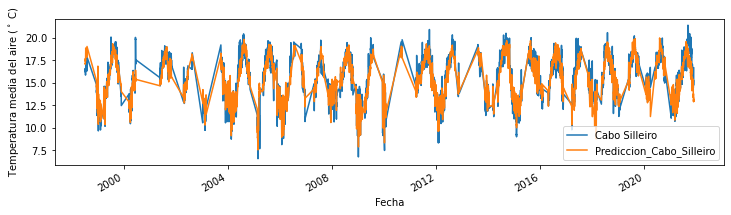

In [218]:
Temp_no_null['Cabo Silleiro'].plot()
Temp_no_null['Prediccion_Cabo_Silleiro'].plot(xlabel='Fecha',ylabel='Temperatura media del aire ($^\circ$ C)',figsize=(12,3))
plt.legend()

Con este ejemplo se puede apreciar la eficacia de predicción de las redes neuronales, que aún es mejorable, y su potencial para completar en un futuro los datos faltantes de las series diarias.